## Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow_addons
!pip install tensorflow-io
!pip install diskarray

     |████████████████████████████████| 1.1 MB 5.4 MB/s 
     |████████████████████████████████| 23.4 MB 1.9 MB/s 
     |████████████████████████████████| 4.9 MB 5.4 MB/s 
     |████████████████████████████████| 509 kB 32.9 MB/s 
  Created wheel for basescript: filename=basescript-0.2.9-py3-none-any.whl size=9974 sha256=b1c885a0672c5ca1e4ba3317ed4690ed7ecf664bd0b803501da61649040e275b
  Stored in directory: /root/.cache/pip/wheels/c1/2e/c1/9604a0e77589c083be3491b1575080103f5f11b9c2c31c7c9e
  Created wheel for numpy: filename=numpy-1.14.3-cp37-cp37m-linux_x86_64.whl size=7641613 sha256=8481aa6e73df81a9dc9d870e1c47b9775df7b312a6a69042627958cdd570660a
  Stored in directory: /root/.cache/pip/wheels/cb/38/86/4ac7ecc2bf189cfe58fb0148b61ccc4b17d00dfcec88d5b973
Successfully built basescript numpy
  Attempting uninstall: six
    Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0
  Attempting uninstall: pytz
    Found existing installati

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl
import tensorflow_addons as tfa
import sklearn.preprocessing as preprocessing
import sklearn
from sklearn.model_selection import *
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow_io as tfio

import datetime as dt
import diskarray as da
import time
import pathlib as path
import os
from io import StringIO
import math
import json
import requests
import random
from tqdm.notebook import trange, tqdm
import regex as re
import gzip
import IPython

In [ ]:
# Setup paths
paths = []

BASE_PATH = '/content/drive/MyDrive/DL/Acoustic-Source-Detection/'
paths.append(BASE_PATH)

BASE_MODELS_PATH = '/content/drive/MyDrive/DL/Acoustic-Source-Detection/models'
paths.append(BASE_MODELS_PATH)

BASE_SIGNALS_PATH = '/content/drive/MyDrive/DL/Acoustic-Source-Detection/signals'
paths.append(BASE_SIGNALS_PATH)

for path in paths:
  if os.path.exists(path):
    continue
  os.makedirs(path)

%cd $BASE_PATH
!ls

/content/drive/MyDrive/DL/Acoustic-Source-Detection
'Acoustic Source Localization.ipynb'   models	 transformed_data
 model_checkpoints		       signals


## Dataset

In [ ]:
file_names = ['C1', 'C2', 'C3']

### Saving

In [ ]:
# directories = os.listdir()[:1]

# X = {f: [] for f in file_names}
# Y = {f: [] for f in file_names}

# # For each data_(\d*) direcotory
# for dir in tqdm(directories):
#   subdirectories = os.listdir(dir)

#   # For each X_(\d*)_Y_(\d*) direcotory
#   for subdir in tqdm(subdirectories):
#     s = re.search('X_(\d*)_Y_(\d*)', subdir, re.IGNORECASE)
#     if not s:
#       continue
#     x = s.group(1)
#     y = s.group(2)
    
#     # For each C(\d*) file
#     for f in file_names:
#       if f not in os.listdir(os.path.join(dir, subdir)):
#         continue
        
#       arr = pd.read_csv(os.path.join(dir, subdir, f)).to_numpy()[:-1].reshape(-1).astype(np.int8)
#       X[f].append(arr)
#       Y[f].append((x, y))

In [ ]:
# for f in file_names:
#   np.save('/content/' + f, np.vstack(X[f]))
#   np.save('/content/Y_' + f, np.vstack(Y[f]))

In [ ]:
# for f in file_names:
#   !gzip -k "/content/{f}.npy

In [ ]:
# for f in file_names:
#   !cp "/content/{f}.npy" "/content/drive/MyDrive/DL/Sonar-Source-Detection/{f}.npy"
#   !cp "/content/Y_{f}.npy" "/content/drive/MyDrive/DL/Sonar-Source-Detection/Y_{f}.npy"

### Loading

In [ ]:
temp_dir = '/content/temp/'
if not os.path.exists(temp_dir):
  os.makedirs(temp_dir)
X = None
Y = None
fp = da.DiskArray(os.path.join(temp_dir, 'X.npy'), dtype=np.float32, shape=(0,99999))

base_path = 'signals/'
for dir in os.listdir(base_path):
  for subdir in os.listdir(os.path.join(base_path, dir)):
    if dir == '.ipynb_checkpoints' or subdir == '.ipynb_checkpoints':
      continue

    path = os.path.join(base_path, dir, subdir) + '/'
    print(path)
    for f in file_names:
      if f + '.npy.gz' not in os.listdir(path):
        continue
      gzf = gzip.GzipFile(path + f + '.npy.gz', "rb")
      # X[f].append(np.load(gzf).astype(np.int32))
      X = np.load(gzf).astype(np.int32) 
      # fp = np.memmap(os.path.join(temp_dir, 'X.npy'), dtype='float64', mode='w+', shape=X.shape)
      fp.extend(X)
      # fp_tmp.flush()

      if Y is not None:
        Y = np.r_[Y, np.load(path + 'Y_' + f + '.npy').astype(np.int32)]
      else:
        Y = np.load(path + 'Y_' + f + '.npy').astype(np.int32)

signals/m2/Data/
signals/m1/Data_1/
signals/m1/Data_2/
signals/m1/Data_3/
signals/m1/Data_6/
signals/m1/Data_7/


### Loading - Transformed Data

In [ ]:
# t_files = {'X_train_norm':X_train_norm,
#         'X_val_norm':X_val_norm,
#         'X_test_norm':X_test_norm,
#         'Y_train_norm':Y_train_norm,
#         'Y_val_norm':Y_val_norm,
#         'Y_test_norm':Y_test_norm,
#       }
  
# dir = 'transformed_data'
# if not os.path.exists(dir):
#   os.mkdir(dir)

# for f in t_files.keys():
#   tmp_arr = t_files[f][:, ::10]
#   np.save(os.path.join(dir, f), tmp_arr)

In [ ]:
# BUGGY

# t_files = ['X_train_norm', 'X_val_norm', 'X_test_norm', 'Y_train_norm', 'Y_val_norm', 'Y_test_norm']
# dir = 'transformed_data'
# assert os.path.exists(dir)

# for f in t_files:
#   arr = np.load(os.path.join(dir, f + '.npy'))
#   exec(f + '=arr')

In [ ]:
# X_train_norm.shape

(1728, 10000)

## Preprocessing

In [ ]:
period = 10

X_data = fp[:, ::period]
Y_data = Y

X_data.shape, Y_data.shape

((21542, 10000), (21542, 2))

### Filter noise


In [ ]:
X_data_tmp = X_data
Y_data_tmp = Y_data

In [ ]:
arr = np.abs(X_data_tmp)
is_noise = arr.mean(axis=1) * 1/arr.std(axis=1) * 1.15 >= ((arr.max(axis=1) + arr.min(axis=1)) / 2)*0.75

X_data = X_data_tmp[np.logical_not(is_noise), X_data.shape[1] // 2:]
Y_data = Y_data_tmp[np.logical_not(is_noise)]

print(X_data.shape, Y_data.shape)

(10427, 5000) (10427, 2)


Is noise: False


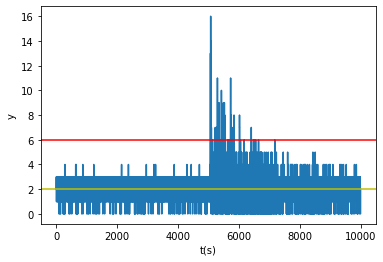

In [ ]:
idx = random.randint(0, len(X_data_tmp))
arr = np.abs(X_data_tmp[idx])

plt.plot(arr)
y = ((arr.max() + arr.min()) / 2)*0.75
mean = arr.mean() * 1/arr.std() * 1.15

plt.axhline(y=y, color='r')
plt.axhline(y=mean, color='y')

plt.xlabel('t(s)')
plt.ylabel('y')

print(f'Is noise: {mean >= y}')

(10427, 5000)


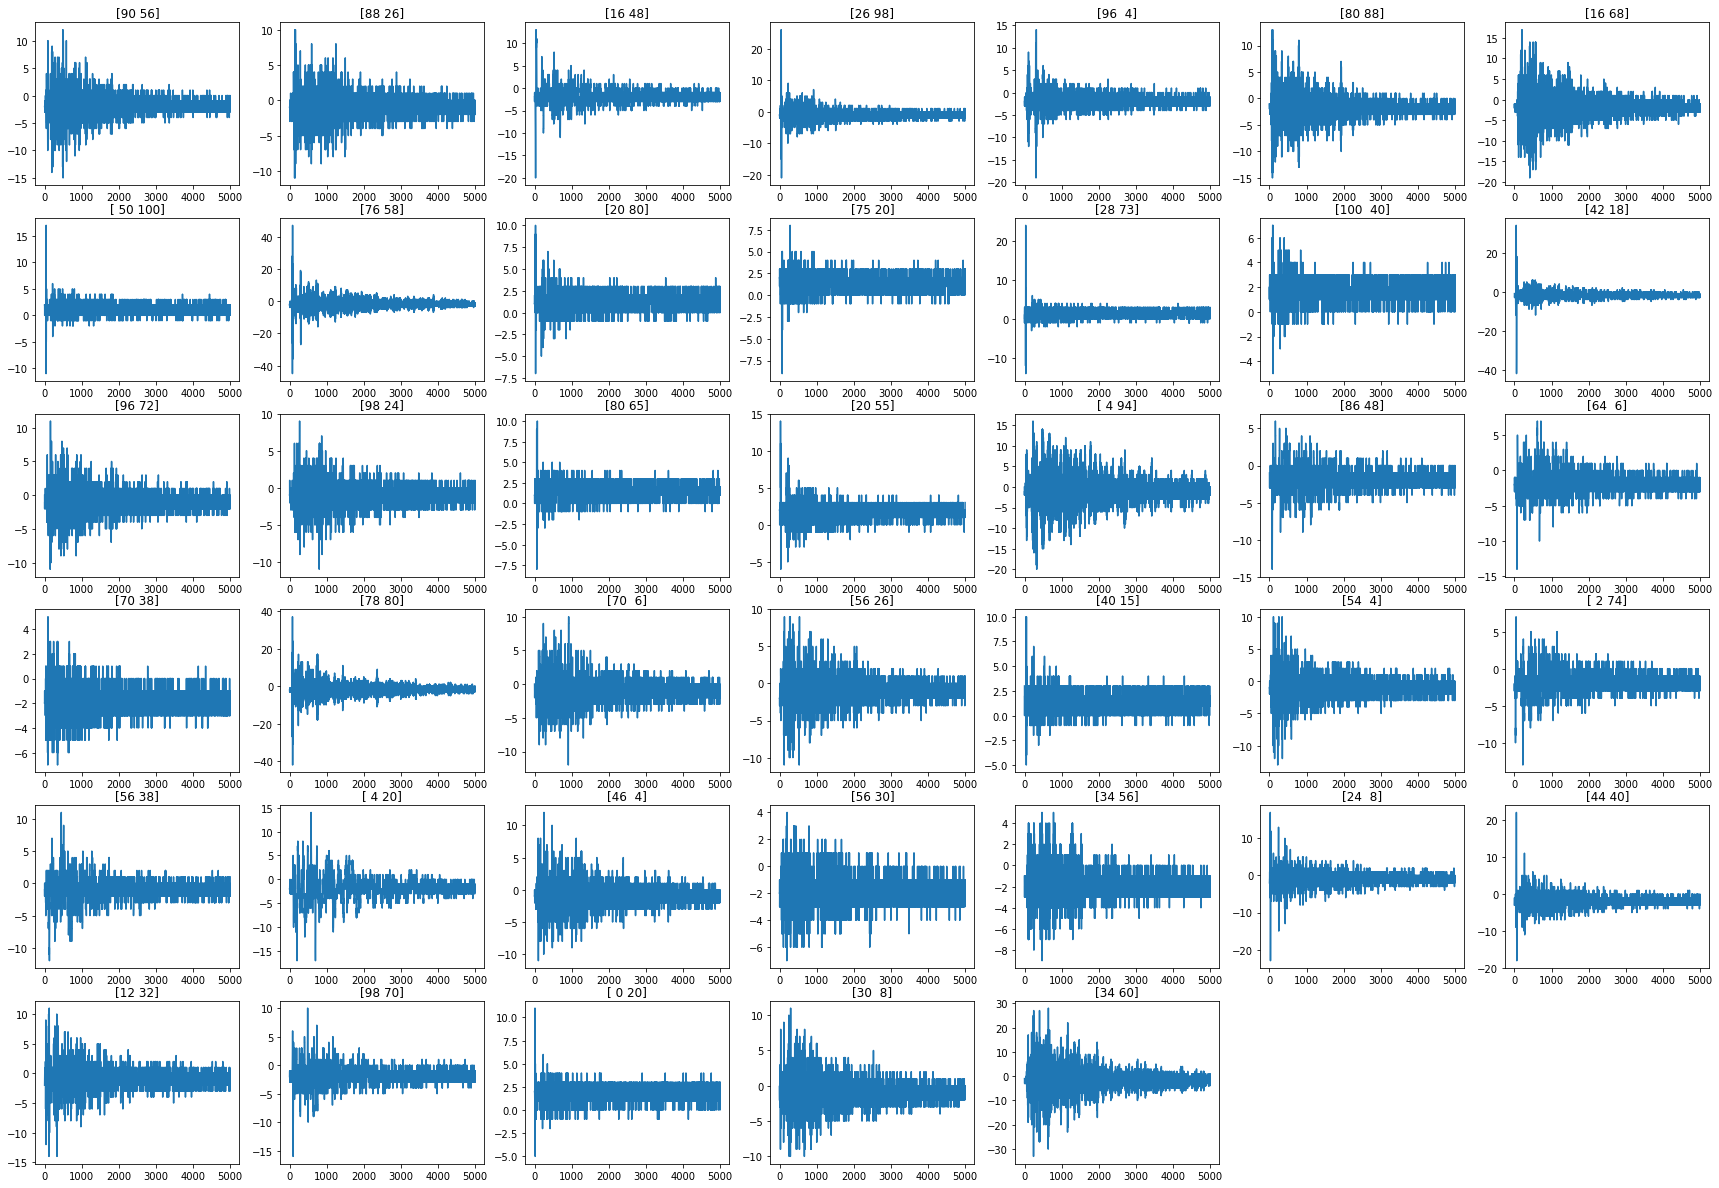

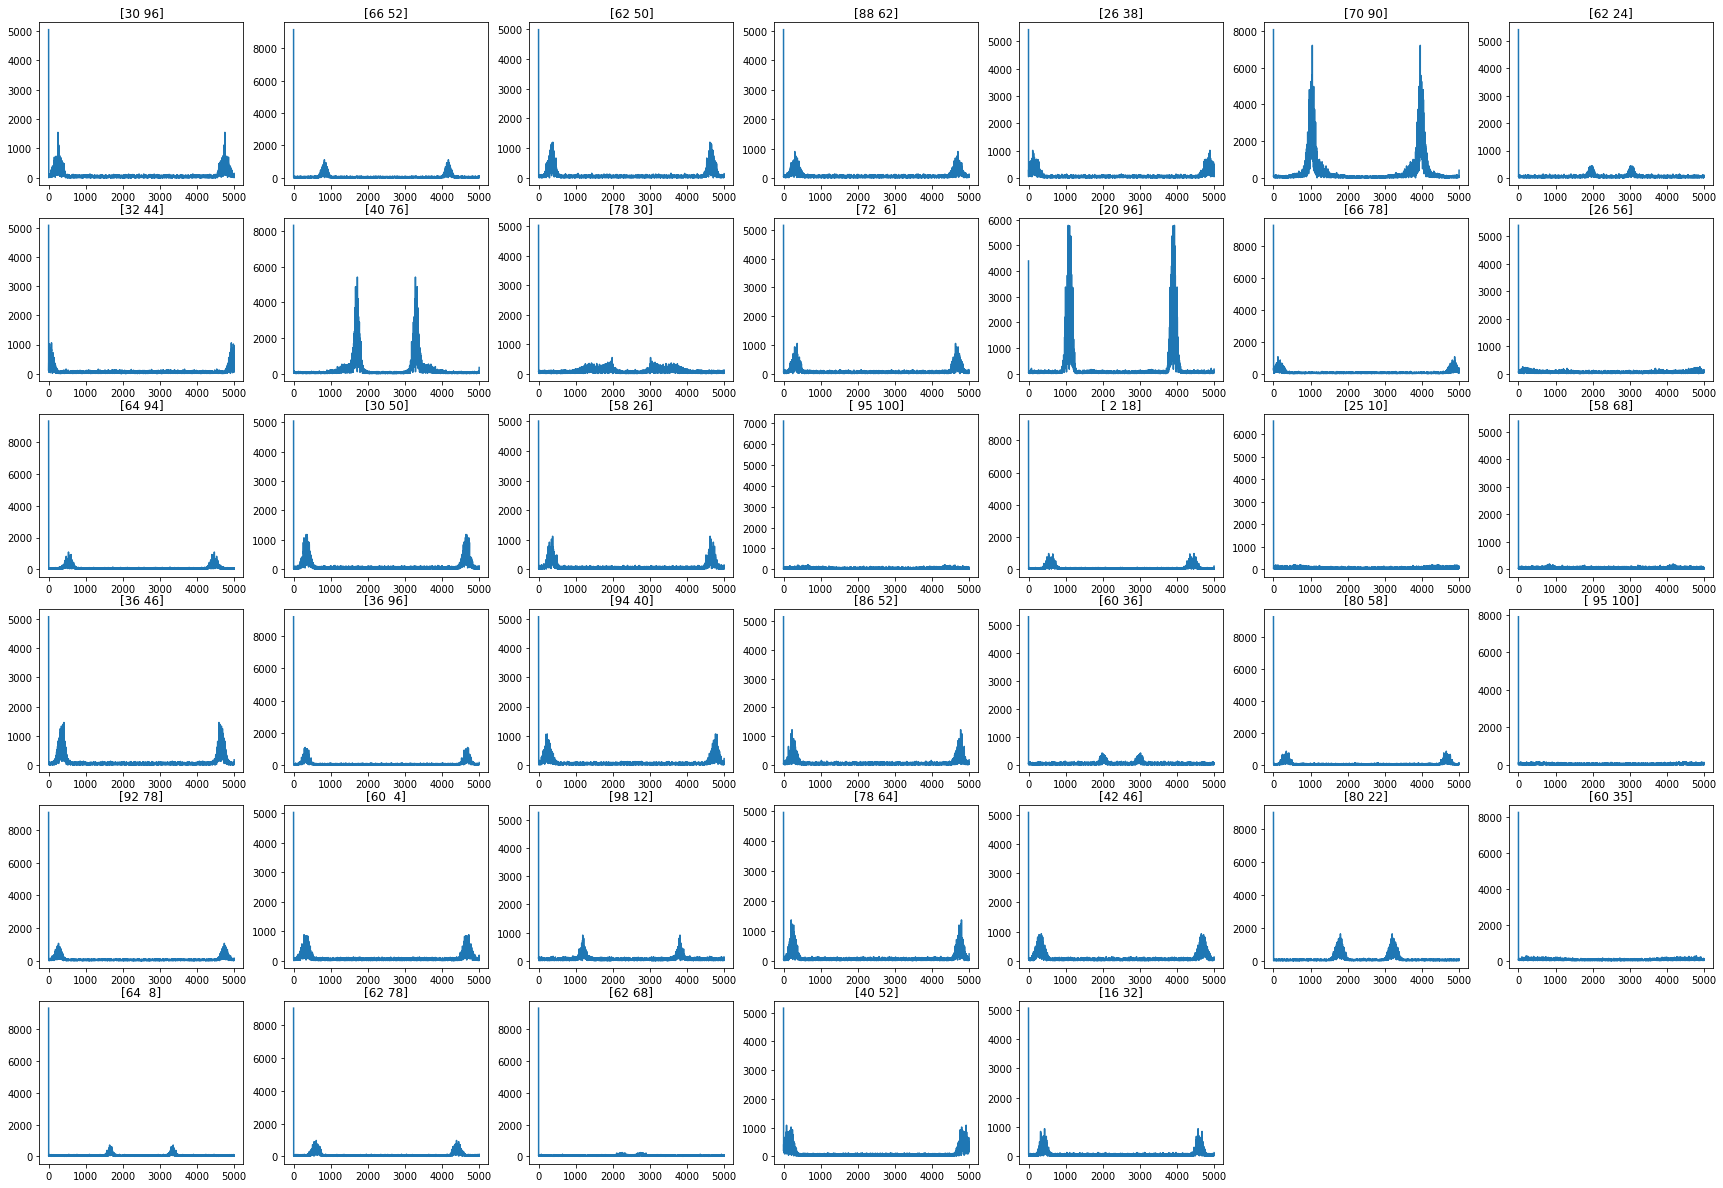

In [ ]:
upper_bound = 40
rows = int(upper_bound**0.5)
cols = math.ceil(upper_bound / rows)

plt.figure(figsize=(rows*5, cols*3))
for i in range(upper_bound):
  idx = random.randint(0, len(X_data))
  plt.subplot(rows, cols, i+1)
  # plt.plot(tf.signal.fft(X_data[i]))
  plt.plot(X_data[idx])
  plt.title(str(Y_data[idx]))

plt.figure(figsize=(rows*5, cols*3))
for i in range(upper_bound):
  idx = random.randint(0, len(X_data))
  plt.subplot(rows, cols, i+1)
  plt.plot(tf.abs(tf.signal.fft(X_data[idx])))
  plt.title(str(Y_data[idx]))

print(X_data.shape)

### Split the data

In [ ]:
val_split = 0.07
test_split = 0.03

(X_train, X_test, Y_train, Y_test) = train_test_split(X_data, Y_data, test_size=test_split, shuffle=True)
(X_train, X_val, Y_train, Y_val) = train_test_split(X_train, Y_train, test_size=val_split, shuffle=True)

print(f'Train set shapes: {X_train.shape}, {Y_train.shape}')
print(f'Val set shapes: {X_val.shape}, {Y_val.shape}')
print(f'Test set shapes: {X_test.shape}, {Y_test.shape}')

Train set shapes: (9406, 5000), (9406, 2)
Val set shapes: (708, 5000), (708, 2)
Test set shapes: (313, 5000), (313, 2)


### Normalization

In [ ]:
scaler_X, scaler_Y = preprocessing.StandardScaler(), preprocessing.StandardScaler()

X_train_norm = scaler_X.fit_transform(X_train.T).T
X_val_norm = scaler_X.fit_transform(X_val.T).T
X_test_norm = scaler_X.fit_transform(X_test.T).T

Y_train_norm = scaler_Y.fit_transform(Y_train)
Y_val_norm = scaler_Y.transform(Y_val)
Y_test_norm = scaler_Y.transform(Y_test)

In [ ]:
X_train_norm.mean(axis=1), X_val_norm.mean(axis=1)

(array([-4.5776369e-09, -1.5258789e-09,  9.1552739e-09, ...,
        -1.3732910e-08, -1.5258790e-08,  6.8664550e-09], dtype=float32),
 array([ 3.0517577e-09, -3.0517577e-09,  0.0000000e+00, -7.6293949e-09,
         8.3923339e-09,  4.5776369e-09,  1.2207031e-08, -1.2207031e-08,
        -4.9591065e-09, -3.8146974e-09, -1.1444092e-08, -5.3405760e-09,
         1.5258789e-09,  9.1552739e-09,  2.2888185e-09,  1.0299683e-08,
        -1.0871887e-08,  7.6293943e-10, -3.0517577e-09, -3.0517577e-09,
        -9.1552739e-09, -3.8146974e-09,  5.3405760e-09,  1.3351441e-08,
        -5.6266787e-09,  1.9073486e-08,  9.9182129e-09,  1.2016296e-08,
         9.1552739e-09,  4.5776369e-09,  2.2888184e-08,  0.0000000e+00,
        -9.5367436e-10, -1.7166137e-09, -1.2207031e-08,  6.1035155e-09,
        -6.1035155e-09,  1.0681152e-08,  7.6293943e-10, -1.1444092e-09,
         6.8664550e-09,  7.6293949e-09,  7.2479249e-09, -1.3732910e-08,
         3.0517580e-08,  7.6293943e-10,  8.3923339e-09,  9.1552739e-09,
  

In [ ]:
Y_train_norm.mean(axis=0), Y_val_norm.mean(axis=0)

(array([-2.20250496e-16, -7.29269930e-17]), array([-0.03486141, -0.02055295]))

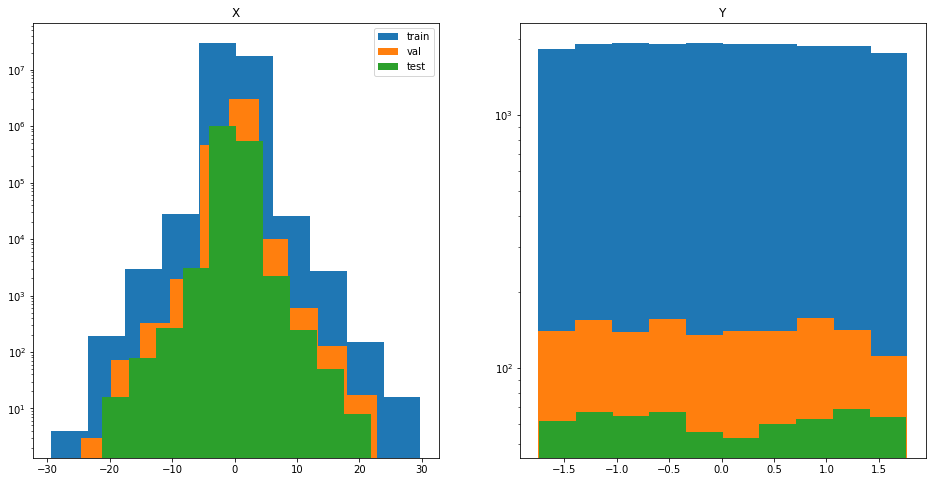

In [ ]:
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.hist(X_train_norm.flatten(), label='train')
plt.hist(X_val_norm.flatten(), label='val')
plt.hist(X_test_norm.flatten(), label='test')
plt.title('X')
plt.yscale('log')
plt.legend()

plt.subplot(1,2,2)
plt.hist(Y_train_norm.flatten())
plt.hist(Y_val_norm.flatten())
plt.hist(Y_test_norm.flatten())
plt.yscale('log')
plt.title('Y')

plt.show()

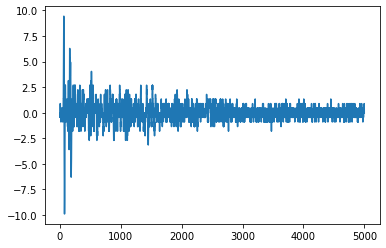

In [ ]:
plt.plot(X_train_norm[random.randint(0, len(X_train_norm))-1])

## Data generation



#### Definition

In [ ]:
class DataGenerator:
  def __init__(self, batch_size=32, period=10, map_type=None, X_train=X_train_norm, X_val=X_val_norm, X_test=X_test_norm, Y_train=Y_train_norm, Y_val=Y_val_norm, Y_test=Y_test_norm):
    assert len(X_train.shape) == len(X_val.shape) == len(X_test.shape) == 2
    assert len(Y_train.shape) == len(Y_val.shape) == len(Y_test.shape) == 2

    self.batch_size = batch_size
    self.period = period
    
    self.X_train = X_train.reshape(X_train.shape + (1,))
    self.X_val = X_val.reshape(X_val.shape + (1,))
    self.X_test = X_test.reshape(X_test.shape + (1,))

    self.Y_train = Y_train
    self.Y_val = Y_val
    self.Y_test = Y_test
      
    self.set_types = ['train', 'val', 'test']

    map_types = [None, 'merged-fft', 'fft', 'spectrogram']
    assert map_type in map_types
    self.map_type = map_type

    self.ds = dict(zip(self.set_types, [None]*len(self.set_types)))

    self.vector_shapes = None
    if map_type is None:
      self.vector_shapes = (self.X_train[:, ::self.period].shape[1:], self.Y_train.shape[1:])

    # Minimally load the train set
    self.train

  def __repr__(self):
    return '\n'.join([
          f'batch_size: {self.batch_size}',
          f'X shape: {self.X.shape}',
          f'Y shape: {self.Y.shape}',
    ])

#### Plot

In [ ]:
def plot(self, model=None, plot_col='close', max_plots=10, plot_ds='train', sz=64):
  assert plot_ds in ['train', 'val', 'test']
  if plot_ds == 'train':
    rand_skip = random.randint(1, len(data_gen.train)-1)
    inputs, labels = next(iter(self.train.skip(rand_skip).take(1)))
  elif plot_ds == 'val':
    rand_skip = random.randint(1, len(data_gen.val)-1)
    inputs, labels = next(iter(self.val.skip(rand_skip).take(1)))
  else:
    rand_skip = random.randint(1, len(data_gen.test)-1)
    inputs, labels = next(iter(self.test.skip(rand_skip).take(1)))

  indices = np.random.permutation(len(inputs))

  plt.figure(figsize=(12, 8))
  max_n = min(max_plots, len(inputs))
  for n in range(max_n):
    color = ['#' + ''.join([random.choice('ABCDEF0123456789') for i in range(6)])][0]
    idx = indices[n]
    # plt.ylabel(f'{plot_col} [normed]')
    label = None
    if n == 0:
      label = 'labels'
    plt.scatter(labels[n, 0], labels[n, 1], color=color, label=label, marker='o', s=sz)

    if model is not None:
      predictions = model(inputs)
      
      if n == 0:
        label = 'predictions'
      
      plt.scatter(predictions[n, 0], predictions[n, 1], label=label, marker='X', c=color, s=sz)

  plt.xlabel('x')
  plt.ylabel('y')
  plt.title(plot_ds)
  plt.legend()

DataGenerator.plot = plot

#### Map functions

In [ ]:
def get_fftX(self, X, Y):
  X = tf.cast(X, tf.complex64)
  fft = tf.abs(tf.signal.fft(X[:, 0]))
  fft = fft[len(fft)//2:, tf.newaxis]
  return fft, Y

def get_merged_fftX(self, X, Y):
  X = tf.cast(X, tf.complex64)
  fft = tf.abs(tf.signal.fft(X[:, 0]))
  fft = fft[len(fft)//2:, tf.newaxis]
  return np.c_[fft, Y]

def get_spectrogramX(self, X, Y, frame_len=64, frame_step=32, fft_len=128):
  X = tf.cast(X, tf.float64)
  X = tf.squeeze(X)
  spectrogram = tf.abs(tfio.audio.spectrogram(X, frame_len, frame_step, fft_len))
  spectrogram = spectrogram[..., tf.newaxis]
  return (spectrogram, Y)

def sig_normalizeX(self, X, Y, axis):
  X_min = tf.reduce_min(X, axis=axis, keepdims=True)
  X_max = tf.reduce_max(X, axis=axis, keepdims=True)

  X = (X - X_min) / (X_max - X_min)
  
  return X, Y

def set_vector_shapes(self, X, Y):
  if self.vector_shapes is None:
    self.vector_shapes = (X.shape, Y.shape)
  return X, Y

DataGenerator.get_spectrogramX = get_spectrogramX
DataGenerator.get_fftX = get_fftX
DataGenerator.get_merged_fftX = get_merged_fftX
DataGenerator.sig_normalizeX = sig_normalizeX
DataGenerator.set_vector_shapes = set_vector_shapes

#### tf.data.Dataset object

In [ ]:
def make_dataset(self, data_X, data_Y, shuffle=True):
  data_X = np.real(np.array(data_X, dtype=np.float64)[:, ::self.period])
  data_Y = np.array(data_Y, dtype=np.float64)

  ds = tf.data.Dataset.from_tensor_slices((data_X, data_Y))
  
  # if self.map_type is None:
  #   ds = ds.map(lambda X, Y: self.sig_normalizeX(X, Y, axis=0), num_parallel_calls=tf.data.experimental.AUTOTUNE)
  if self.map_type == 'fft':
    ds = ds.map(self.get_fftX, num_parallel_calls=tf.data.AUTOTUNE)
    # ds = ds.map(lambda X, Y: self.sig_normalizeX(X, Y, axis=0), num_parallel_calls=tf.data.experimental.AUTOTUNE)
  elif self.map_type == 'merged-fft':
    ds = ds.map(self.get_merged_fftX, num_parallel_calls=tf.data.AUTOTUNE)
  elif self.map_type == 'spectrogram':
    ds = ds.map(self.get_spectrogramX, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.map(lambda X, Y: self.sig_normalizeX(X, Y, axis=1), num_parallel_calls=tf.data.experimental.AUTOTUNE)
  
  ds.map(self.set_vector_shapes)
  ds = ds.cache()

  ds = ds.shuffle(len(ds))
  ds = ds.batch(self.batch_size)

  ds = ds.prefetch(tf.data.AUTOTUNE)

  return ds

DataGenerator.make_dataset = make_dataset

In [ ]:
@property
def train(self):
  if self.ds['train'] is None:
    self.ds['train'] = self.make_dataset(self.X_train, self.Y_train)
  return self.ds['train']

@property
def val(self):
  if self.ds['val'] is None:
    self.ds['val'] = self.make_dataset(self.X_val, self.Y_val)
  return self.ds['val']

@property
def test(self):
  if self.ds['test'] is None:
    self.ds['test'] = self.make_dataset(self.X_test, self.Y_test)
  return self.ds['test']

@property
def vector_shapes():
  return self.__vector_shapes

DataGenerator.train = train
DataGenerator.val = val
DataGenerator.test = test

## Raw Models

In [ ]:
# Setup data generation
data_gen = DataGenerator(batch_size=32, period=1, map_type=None)

n_features = X_train_norm.shape[1]
out_cardinality = Y_train_norm.shape[1]
vector_shapes = data_gen.vector_shapes

# Setup paths
RAW_MODELS_PATH = os.path.join(BASE_PATH, 'raw')
print(f'Raw models path: {RAW_MODELS_PATH}')

Raw models path: /content/drive/MyDrive/DL/Acoustic-Source-Detection/raw


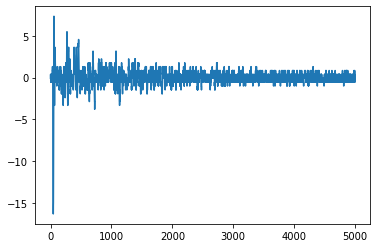

In [ ]:
x, y = next(iter(data_gen.train))
plt.plot(x[0, :, 0])

In [ ]:
def compile_and_fit(model, data_train, data_val, optimizer=tf.keras.optimizers.Adam(), patience=2, lr=0.001, epochs=40):
  early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience*2,
                                                    mode='min')
  reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=patience, mode='auto', min_delta=1e-4)

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=optimizer,
                metrics=[tf.metrics.MeanAbsoluteError(), tfa.metrics.r_square.RSquare(dtype=tf.float32, y_shape=(out_cardinality,))])

  tf.keras.backend.set_value(model.optimizer.learning_rate, lr)

  history = model.fit(data_train, epochs=epochs,
                      validation_data=data_val,
                      callbacks=[reduce])
  return history

### Regression

#### Linear

In [ ]:
def modelf(input_shape, out_cardinality):
  X_input = tfl.Input(input_shape)
  X = X_input

  # X = tfl.AveragePooling1D(3)(X)
  # X = tfl.AveragePooling1D(3)(X)
  # X = tfl.AveragePooling1D(3)(X)
  X = tfl.Flatten()(X)
  
  X = tfl.Dense(32)(X)
  X = tfl.BatchNormalization(axis=-1)(X)
  X = tfl.Activation('relu')(X)
  
  X = tfl.Dense(10)(X)
  X = tfl.BatchNormalization(axis=-1)(X)
  X = tfl.Activation('relu')(X)

  X = tfl.Dense(out_cardinality)(X)
  
  return tf.keras.Model(inputs=X_input, outputs=X)

In [ ]:
linear_model1 = modelf(vector_shapes[0], out_cardinality)
linear1_optimizer = tf.keras.optimizers.Adam()

linear_model1.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 5000, 1)]         0         
                                                                 
 flatten_6 (Flatten)         (None, 5000)              0         
                                                                 
 dense_14 (Dense)            (None, 32)                160032    
                                                                 
 batch_normalization_28 (Bat  (None, 32)               128       
 chNormalization)                                                
                                                                 
 activation_28 (Activation)  (None, 32)                0         
                                                                 
 dense_15 (Dense)            (None, 10)                330       
                                                           

In [ ]:
model = linear_model1
history = compile_and_fit(model, data_train=data_gen.train, data_val=data_gen.val,
                          optimizer=linear1_optimizer, lr=1e-3, patience=4, epochs=200)

IPython.display.clear_output()
model.evaluate(data_gen.train)
model.evaluate(data_gen.val)
model.evaluate(data_gen.test)

3/3 [==============================] - 0s 7ms/step - loss: 0.1354 - mean_absolute_error: 0.3016 - r_square: -0.6577


[0.13543789088726044, 0.3016307055950165, -0.6576828956604004]

In [ ]:
model = linear_model1
history = model.fit(X_train_norm, Y_train_norm, validation_data=(X_val_norm, Y_val_norm), epochs=50, batch_size=32)

IPython.display.clear_output()
model.evaluate(data_gen.train)
model.evaluate(data_gen.val)
model.evaluate(data_gen.test)

Epoch 1/50
69/69 [==============================] - 1s 11ms/step - loss: 0.0091 - mean_absolute_error: 0.0747 - r_square: 0.8948 - val_loss: 0.1379 - val_mean_absolute_error: 0.3062 - val_r_square: -0.5704
Epoch 2/50
69/69 [==============================] - 1s 7ms/step - loss: 0.0095 - mean_absolute_error: 0.0764 - r_square: 0.8907 - val_loss: 0.1381 - val_mean_absolute_error: 0.3064 - val_r_square: -0.5727
Epoch 3/50
69/69 [==============================] - 1s 7ms/step - loss: 0.0091 - mean_absolute_error: 0.0733 - r_square: 0.8945 - val_loss: 0.1378 - val_mean_absolute_error: 0.3060 - val_r_square: -0.5691
Epoch 4/50
69/69 [==============================] - 0s 7ms/step - loss: 0.0079 - mean_absolute_error: 0.0692 - r_square: 0.9085 - val_loss: 0.1380 - val_mean_absolute_error: 0.3062 - val_r_square: -0.5712
Epoch 5/50
69/69 [==============================] - 1s 7ms/step - loss: 0.0081 - mean_absolute_error: 0.0698 - r_square: 0.9067 - val_loss: 0.1379 - val_mean_absolute_error: 0.306

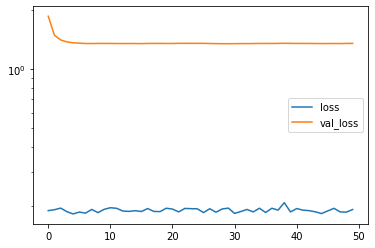

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.yscale('log')

plt.legend()

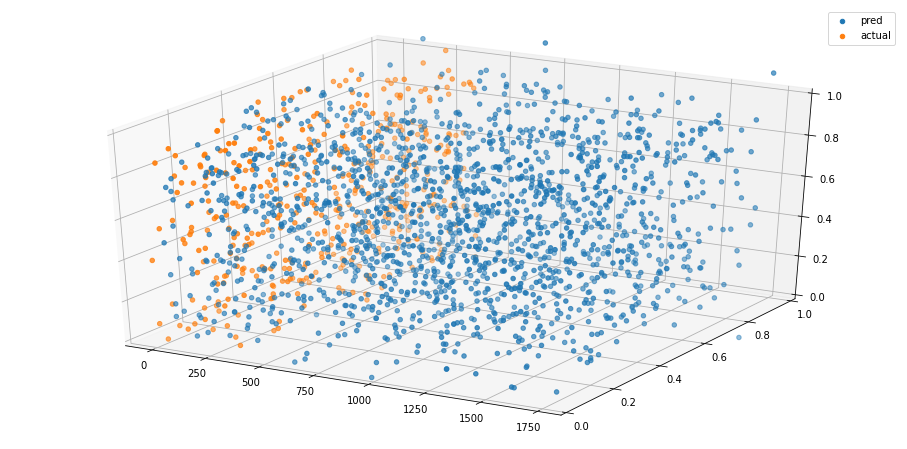

In [ ]:
y_pred = dense_model.predict()

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(np.arange(len(y_pred)), y_pred[:, 0], y_pred[:, 1], label='pred')
ax.scatter(np.arange(len(Y_train_norm)), Y_train_norm[:, 0], Y_train_norm[:, 1], label='actual')

ax.set_ylim((0,1))
ax.set_zlim((0,1))
ax.legend()

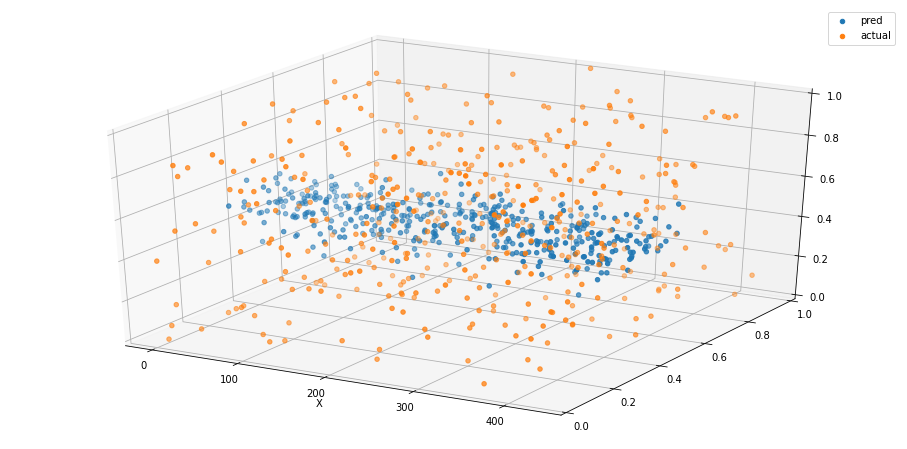

In [ ]:
y_pred = dense_model.predict(X_val_norm)

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(np.arange(len(y_pred)), y_pred[:, 0], y_pred[:, 1], label='pred')
ax.scatter(np.arange(len(Y_val_norm)), Y_val_norm[:, 0], Y_val_norm[:, 1], label='actual')

ax.set_ylim((0,1))
ax.set_zlim((0,1))

ax.set_xlabel('X')
ax.legend()

#### Dense

In [ ]:
def modelf(input_shape):
  X_input = tfl.Input(input_shape)
  X = X_input

  X = tfl.Flatten()(X)
  X = tfl.Dense(10)(X)
  X = tfl.Dense(out_cardinality)(X)
  
  
  return tf.keras.Model(inputs=X_input, outputs=X)

In [ ]:
model = modelf(X_data.shape[1:])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 10000)]           0         
                                                                 
 flatten_2 (Flatten)         (None, 10000)             0         
                                                                 
 dense_4 (Dense)             (None, 10)                100010    
                                                                 
 dense_5 (Dense)             (None, 2)                 22        
                                                                 
Total params: 100,032
Trainable params: 100,032
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = compile_and_fit(model, data_train=data_gen.train, data_val=data_gen.val, lr=0.001, patience=3)

IPython.display.clear_output()
model.evaluate(X_train_norm, Y_train_norm)
model.evaluate(X_val_norm, Y_val_norm)
model.evaluate(X_test_norm, Y_test_norm)

1/1 [==============================] - 0s 35ms/step - loss: 3.7370 - mean_absolute_error: 1.6204 - r_square: -3.9429


[3.737001895904541, 1.62044358253479, -3.942863941192627]

In [ ]:
dense_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 99999, 1)          0         
                                                                 
 conv1d (Conv1D)             (None, 1000, 3)           297003    
                                                                 
 batch_normalization (BatchN  (None, 1000, 3)          12        
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 3000)              0         
                                                                 
 dense (Dense)               (None, 2)                 6002      
                                                                 
Total params: 303,017
Trainable params: 303,011
Non-trainable params: 6
__________________________________________________

In [ ]:
reg_val = 0.001
dense_model = tf.keras.Sequential([
    tfl.Reshape([-1,1]),
    tfl.Conv1D(3, 99900, 1),
    tfl.BatchNormalization(),
    tfl.Flatten(),
    tfl.Dense(out_cardinality)
])

history = compile_and_fit(dense_model, data_train=data_gen.train, data_val=data_gen.val, lr=0.001, patience=3)

IPython.display.clear_output()
dense_model.evaluate(X_train_norm, Y_train_norm)
dense_model.evaluate(X_val_norm, Y_val_norm)
dense_model.evaluate(X_test_norm, Y_test_norm)

In [ ]:
reg_val = 0.001
dense_model = tf.keras.Sequential([
    tfl.Flatten(),
    tfl.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_val), bias_regularizer=tf.keras.regularizers.l2(reg_val)),
    tfl.BatchNormalization(),
    tfl.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_val), bias_regularizer=tf.keras.regularizers.l2(reg_val)),
    tfl.BatchNormalization(),
    tfl.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_val), bias_regularizer=tf.keras.regularizers.l2(reg_val)),
    tfl.BatchNormalization(),
    tfl.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_val), bias_regularizer=tf.keras.regularizers.l2(reg_val)),
    tfl.BatchNormalization(),
    tfl.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_val), bias_regularizer=tf.keras.regularizers.l2(reg_val)),
    tfl.BatchNormalization(),
    tfl.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_val), bias_regularizer=tf.keras.regularizers.l2(reg_val)),
    tfl.BatchNormalization(),
    tfl.Dense(out_cardinality)
])

history = compile_and_fit(dense_model, data_train=data_gen.train, data_val=data_gen.val, lr=0.001, patience=3)

IPython.display.clear_output()
dense_model.evaluate(X_train_norm, Y_train_norm)
dense_model.evaluate(X_val_norm, Y_val_norm)
dense_model.evaluate(X_test_norm, Y_test_norm)

8/8 [==============================] - 0s 18ms/step - loss: 0.4788 - mean_absolute_error: 0.4179 - r_square: -2.0304


[0.4787692725658417, 0.4178805351257324, -2.0304207801818848]

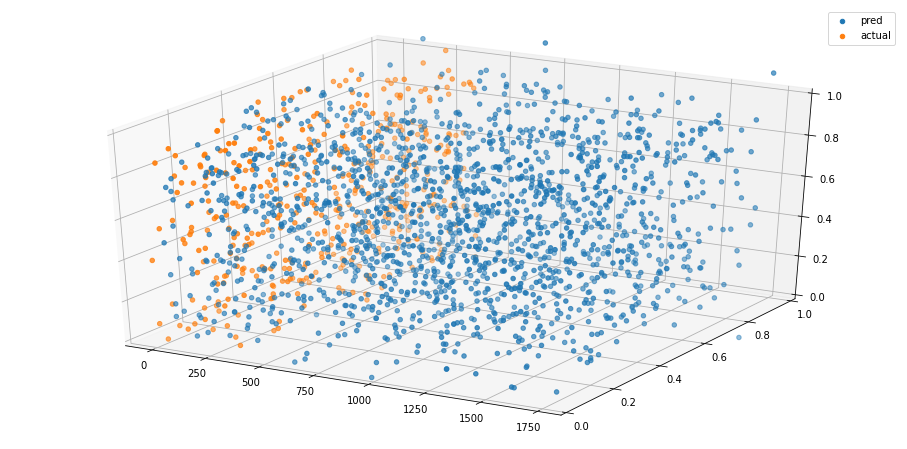

In [ ]:
y_pred = dense_model.predict(X_train_norm)

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(np.arange(len(y_pred)), y_pred[:, 0], y_pred[:, 1], label='pred')
ax.scatter(np.arange(len(Y_train_norm)), Y_train_norm[:, 0], Y_train_norm[:, 1], label='actual')

ax.set_ylim((0,1))
ax.set_zlim((0,1))
ax.legend()

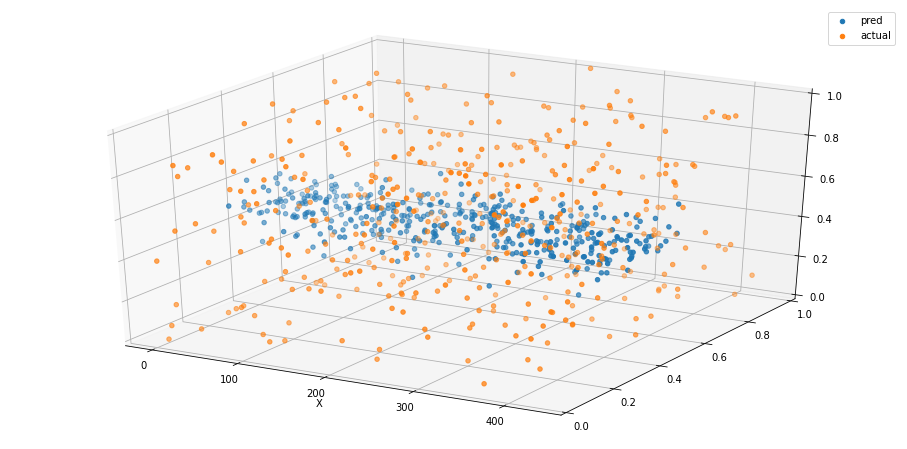

In [ ]:
y_pred = dense_model.predict(X_val_norm)

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(np.arange(len(y_pred)), y_pred[:, 0], y_pred[:, 1], label='pred')
ax.scatter(np.arange(len(Y_val_norm)), Y_val_norm[:, 0], Y_val_norm[:, 1], label='actual')

ax.set_ylim((0,1))
ax.set_zlim((0,1))

ax.set_xlabel('X')
ax.legend()

#### Conv

##### Residual1

In [ ]:
def identity_block(X, filters):
    assert len(filters) == 3

    # Retrieve Filters
    F1, F2, F3 = filters

    # Skip handling
    X_skip = X
    
    # Stage 1
    X = tfl.Conv1D(filters = F1, kernel_size = (1,), strides = (1,), padding = 'valid', kernel_initializer = tf.keras.initializers.glorot_uniform())(X)
    X = tfl.BatchNormalization(axis = 1)(X)
    X = tfl.Activation('relu')(X)
    
    # Stage 2
    X = tfl.Conv1D(filters = F2, kernel_size = (3,), strides = (1,), padding = 'same', kernel_initializer = tf.keras.initializers.glorot_uniform())(X)
    X = tfl.BatchNormalization(axis = 1)(X)
    X = tfl.Activation('relu')(X)
    
    # Stage 3
    X = tfl.Conv1D(filters = F3, kernel_size = (1,), strides = (1,), padding = 'valid', kernel_initializer = tf.keras.initializers.glorot_uniform())(X)
    X = tfl.BatchNormalization(axis = 1)(X)
    
    # Add with skip connection
    X = tfl.Add()([X, X_skip])
    X = tfl.Activation('relu')(X)
    
    return X

In [ ]:
def conv_block(X, filters, s = 2):
    assert len(filters) == 3

    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Skip handling
    X_skip = X
    
    # Stage 1
    X = tfl.Conv1D(filters = F1, kernel_size = (1,), strides = (s,), padding = 'valid', kernel_initializer = tf.keras.initializers.glorot_uniform())(X)
    X = tfl.BatchNormalization(axis = 1)(X)
    X = tfl.Activation('relu')(X)
    
    # Stage 2
    X = tfl.Conv1D(filters = F2, kernel_size = (3,), strides = (1,), padding = 'same', kernel_initializer = tf.keras.initializers.glorot_uniform())(X)
    X = tfl.BatchNormalization(axis = 1)(X)
    X = tfl.Activation('relu')(X)
    
    # Stage 3
    X = tfl.Conv1D(filters = F3, kernel_size = (1,), strides = (1,), padding = 'valid', kernel_initializer = tf.keras.initializers.glorot_uniform())(X)
    X = tfl.BatchNormalization(axis = 1)(X)
    X = tfl.Activation('relu')(X)
    
    # Add with skip connection
    X_skip = tfl.Conv1D(filters = F3, kernel_size = (1,), strides = (s,), padding = 'valid', kernel_initializer = tf.keras.initializers.glorot_uniform())(X_skip)
    X_skip = tfl.BatchNormalization(axis = 1)(X_skip)
    
    X = tfl.Add()([X, X_skip])
    X = tfl.Activation('relu')(X)
    
    return X

In [ ]:
def res_model(input_shape, out_cardinality):
  assert len(input_shape) == 2
  
  X_input = tfl.Input(input_shape)
  X = X_input

  # Initial conv
  X = tfl.Conv1D(64, (7,), strides=5, padding='valid', kernel_initializer = tf.keras.initializers.glorot_uniform())(X)
  X = tfl.BatchNormalization(axis=1)(X)
  X = tfl.Activation('relu')(X)

  # Initial pooling
  X = tfl.MaxPool1D(3, strides=2)(X)

  # Res Level 1
  X = conv_block(X, filters = [64, 64, 256], s = 1)
  X = identity_block(X, [64, 64, 256])
  X = identity_block(X, [64, 64, 256])

  # Res Level 2
  X = conv_block(X, filters = [128, 128, 512], s = 2)

  # Res Level 3
  X = conv_block(X, filters = [256, 256, 1024], s = 2)

  # Final layers
  X = tfl.AveragePooling1D(2, strides=1)(X)
  X = tfl.Flatten()(X)
  X = tfl.Dense(out_cardinality)(X)

  return tf.keras.Model(inputs=X_input, outputs=X)

In [ ]:
conv_res_model1 = res_model(vector_shapes[0], out_cardinality)
conv_res_optimizer = tf.keras.optimizers.Adam()

conv_res_model1.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 5000, 1)]    0           []                               
                                                                                                  
 conv1d_49 (Conv1D)             (None, 999, 64)      512         ['input_4[0][0]']                
                                                                                                  
 batch_normalization_50 (BatchN  (None, 999, 64)     3996        ['conv1d_49[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_50 (Activation)     (None, 999, 64)      0           ['batch_normalization_50[0]

In [ ]:
model = conv_res_model1
history = compile_and_fit(model, data_train=data_gen.train, data_val=data_gen.val,
                          optimizer=conv_res_optimizer, lr=1e-4)

IPython.display.clear_output()
model.evaluate(data_gen.train)
model.evaluate(data_gen.val)
model.evaluate(data_gen.test)

10/10 [==============================] - 0s 34ms/step - loss: 0.6902 - mean_absolute_error: 0.6464 - r_square: 0.3173


[0.6901533007621765, 0.6464439034461975, 0.3173196017742157]

##### Residual2

In [ ]:
def identity_block(X, filters, kern_l2=0.0):
    assert len(filters) == 3

    # Retrieve Filters
    F1, F2, F3 = filters

    # Skip handling
    X_skip = X
    
    # Stage 1
    X = tfl.Conv1D(filters = F1, kernel_size = (1,), strides = (1,), padding = 'valid', kernel_initializer = tf.keras.initializers.glorot_uniform(), kernel_regularizer=tf.keras.regularizers.l2(kern_l2))(X)
    X = tfl.BatchNormalization(axis = 1)(X)
    X = tfl.Activation('relu')(X)
    
    # Stage 2
    X = tfl.Conv1D(filters = F2, kernel_size = (3,), strides = (1,), padding = 'same', kernel_initializer = tf.keras.initializers.glorot_uniform(), kernel_regularizer=tf.keras.regularizers.l2(kern_l2))(X)
    X = tfl.BatchNormalization(axis = 1)(X)
    X = tfl.Activation('relu')(X)
    
    # Stage 3
    X = tfl.Conv1D(filters = F3, kernel_size = (1,), strides = (1,), padding = 'valid', kernel_initializer = tf.keras.initializers.glorot_uniform(), kernel_regularizer=tf.keras.regularizers.l2(kern_l2))(X)
    X = tfl.BatchNormalization(axis = 1)(X)
    
    # Add with skip connection
    X = tfl.Add()([X, X_skip])
    X = tfl.Activation('relu')(X)
    
    return X

In [ ]:
def conv_block(X, filters, s = 2, kern_l2=0.0):
    assert len(filters) == 3

    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Skip handling
    X_skip = X
    
    # Stage 1
    X = tfl.Conv1D(filters = F1, kernel_size = (1,), strides = (s,), padding = 'valid', kernel_initializer = tf.keras.initializers.glorot_uniform(), kernel_regularizer=tf.keras.regularizers.l2(kern_l2))(X)
    X = tfl.BatchNormalization(axis = 1)(X)
    X = tfl.Activation('relu')(X)
    
    # Stage 2
    X = tfl.Conv1D(filters = F2, kernel_size = (3,), strides = (1,), padding = 'same', kernel_initializer = tf.keras.initializers.glorot_uniform(), kernel_regularizer=tf.keras.regularizers.l2(kern_l2))(X)
    X = tfl.BatchNormalization(axis = 1)(X)
    X = tfl.Activation('relu')(X)
    
    # Stage 3
    X = tfl.Conv1D(filters = F3, kernel_size = (1,), strides = (1,), padding = 'valid', kernel_initializer = tf.keras.initializers.glorot_uniform(), kernel_regularizer=tf.keras.regularizers.l2(kern_l2))(X)
    X = tfl.BatchNormalization(axis = 1)(X)
    X = tfl.Activation('relu')(X)
    
    # Add with skip connection
    X_skip = tfl.Conv1D(filters = F3, kernel_size = (1,), strides = (s,), padding = 'valid', kernel_initializer = tf.keras.initializers.glorot_uniform(), kernel_regularizer=tf.keras.regularizers.l2(kern_l2))(X_skip)
    X_skip = tfl.BatchNormalization(axis = 1)(X_skip)
    
    X = tfl.Add()([X, X_skip])
    X = tfl.Activation('relu')(X)
    
    return X

In [ ]:
def res_model2(input_shape, out_cardinality, kern_l2=0.0):
  assert len(input_shape) == 2
  
  X_input = tfl.Input(input_shape)
  X = X_input

  # Initial conv
  X = tfl.Conv1D(64, (7,), strides=5, padding='valid', kernel_initializer = tf.keras.initializers.glorot_uniform(), kernel_regularizer=tf.keras.regularizers.l2(kern_l2))(X)
  X = tfl.BatchNormalization(axis=1)(X)
  X = tfl.Activation('relu')(X)

  # Initial pooling
  X = tfl.MaxPool1D(3, strides=2)(X)

  # Res Level 1
  X = conv_block(X, filters = [64, 64, 256], s = 1, kern_l2=kern_l2)
  X = identity_block(X, [64, 64, 256], kern_l2=kern_l2)
  X = identity_block(X, [64, 64, 256], kern_l2=kern_l2)

  # Res Level 2
  X = conv_block(X, filters = [128, 128, 512], s = 2, kern_l2=kern_l2)

  # Res Level 3
  X = conv_block(X, filters = [256, 256, 1024], s = 2, kern_l2=kern_l2)

  # Final layers
  X = tfl.AveragePooling1D(2, strides=1)(X)
  X = tfl.Flatten()(X)
  X = tfl.Dense(out_cardinality, kernel_regularizer=tf.keras.regularizers.l2(kern_l2))(X)

  return tf.keras.Model(inputs=X_input, outputs=X)

In [ ]:
conv_res_model2 = res_model2(vector_shapes[0], out_cardinality, kern_l2=0.01)
conv_res_optimizer2 = tf.keras.optimizers.Adam()

conv_res_model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5000, 1)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 999, 64)      512         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 999, 64)     3996        ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 999, 64)      0           ['batch_normalization[0][0]']

In [ ]:
# conv_res_model2.save(os.path.join(BASE_MODELS_PATH, 'conv_res_model2'))
# conv_res_model2 = tf.keras.models.load_model(os.path.join(BASE_MODELS_PATH, 'conv_res_model2'))

INFO:tensorflow:Assets written to: /content/drive/MyDrive/DL/Acoustic-Source-Detection/models/conv_res_model2/assets


In [ ]:
model = conv_res_model2
history = compile_and_fit(model, data_train=data_gen.train, data_val=data_gen.val,
                          optimizer=conv_res_optimizer2, lr=1e-4)

IPython.display.clear_output()
model.evaluate(data_gen.train)
model.evaluate(data_gen.val)
model.evaluate(data_gen.test)

Epoch 1/40
294/294 [==============================] - 71s 226ms/step - loss: 2.6489 - mean_absolute_error: 0.3655 - r_square: 0.7878 - val_loss: 3.1018 - val_mean_absolute_error: 0.6861 - val_r_square: 0.2073 - lr: 1.0000e-04
Epoch 2/40
294/294 [==============================] - 65s 222ms/step - loss: 2.4080 - mean_absolute_error: 0.3510 - r_square: 0.8044 - val_loss: 2.8497 - val_mean_absolute_error: 0.6693 - val_r_square: 0.2508 - lr: 1.0000e-04
Epoch 3/40
294/294 [==============================] - 65s 223ms/step - loss: 2.2003 - mean_absolute_error: 0.3403 - r_square: 0.8150 - val_loss: 2.8109 - val_mean_absolute_error: 0.7392 - val_r_square: 0.1016 - lr: 1.0000e-04
Epoch 4/40
294/294 [==============================] - 66s 224ms/step - loss: 2.0226 - mean_absolute_error: 0.3377 - r_square: 0.8188 - val_loss: 2.5011 - val_mean_absolute_error: 0.6653 - val_r_square: 0.2496 - lr: 1.0000e-04
Epoch 5/40
294/294 [==============================] - 66s 224ms/step - loss: 1.8682 - mean_absol

KeyboardInterrupt: ignored

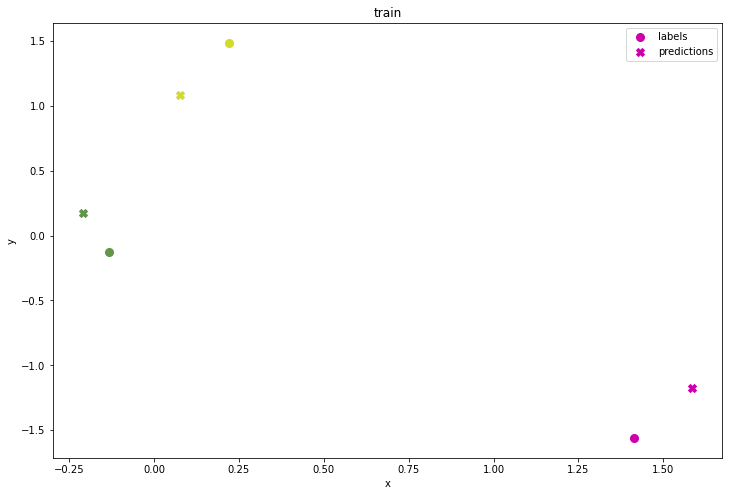

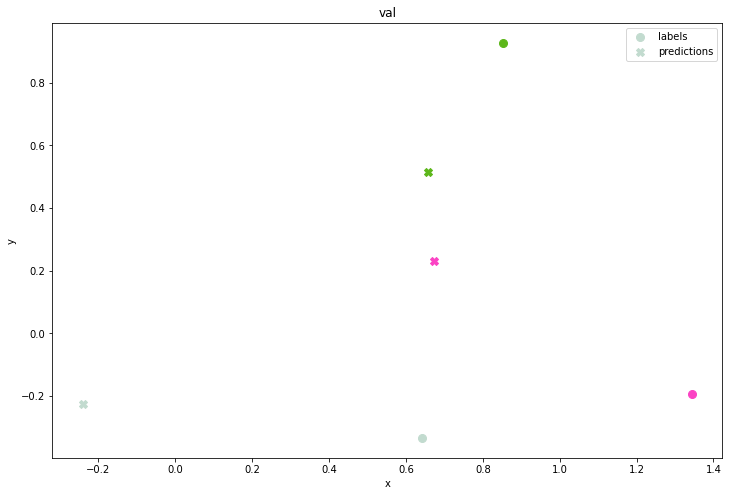

In [ ]:
data_gen.plot(model, max_plots=3, plot_ds='train')
data_gen.plot(model, max_plots=3, plot_ds='val')

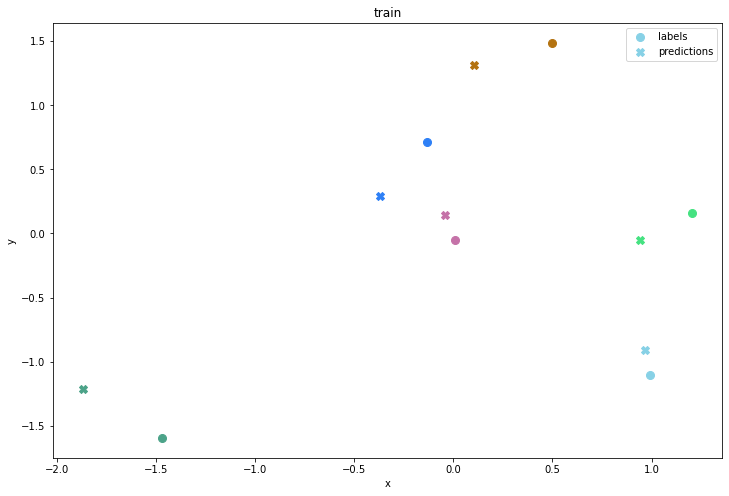

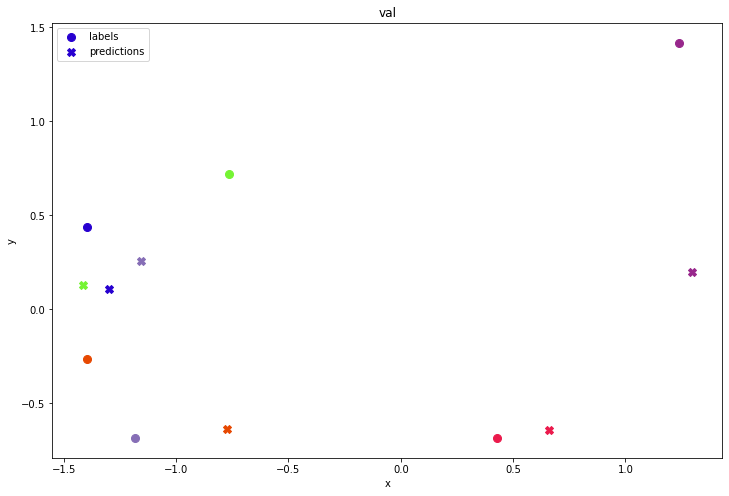

In [ ]:
data_gen.plot(conv_res_model2, max_plots=6, plot_ds='train')
data_gen.plot(conv_res_model2, max_plots=6, plot_ds='val')

##### Conv 1
J. M. Vera-Diaz, D. Pizarro, and J. Macias-Guarasa, “Towards endto-end acoustic localization using deep learning: from audio signal to source position coordinates,” Sensors, vol. 18, no. 10, p. 3418, 2018.

In [ ]:
def conv_block(X, kern_sz, pooling_kern_sz, filters, output_max_pooling=False):
  # Stage 1
  X = tfl.Conv1D(filters, (kern_sz,), padding='valid', kernel_initializer = tf.keras.initializers.glorot_uniform())(X)
  X = tfl.BatchNormalization(axis=-1)(X)
  X = tfl.Activation('relu')(X)

  X = tfl.MaxPool1D(pooling_kern_sz,)(X)

  # Stage 2
  X = tfl.Conv1D(filters, (kern_sz,), padding='same', kernel_initializer = tf.keras.initializers.glorot_uniform())(X)
  X = tfl.BatchNormalization(axis=-1)(X)
  X = tfl.Activation('relu')(X)

  if output_max_pooling:
    X = tfl.MaxPool1D(kern_sz,)(X)

  return X

In [ ]:
def conv1_modelf(input_shape, out_cardinality):
  assert len(input_shape) == 2
  
  X_input = tfl.Input(input_shape)
  X = X_input

  X = conv_block(X, 7, 3, 96)
  X = conv_block(X, 5, 3, 128, output_max_pooling=True)
  
  # Final conv
  X = tfl.Conv1D(128, (3,), padding='same', kernel_initializer = tf.keras.initializers.glorot_uniform())(X)
  X = tfl.BatchNormalization(axis=-1)(X)
  X = tfl.Activation('relu')(X)

  # Final FC‌s
  X = tfl.Flatten()(X)

  X = tfl.Dense(128,)(X)
  X = tfl.BatchNormalization()(X)
  X = tfl.Activation('relu')(X)
  X = tfl.Dropout(0.5)(X)

  X = tfl.Dense(out_cardinality)(X)

  return tf.keras.Model(inputs=X_input, outputs=X)

In [ ]:
conv1_model = conv1_modelf(vector_shapes[0], out_cardinality)
optimizer = tf.keras.optimizers.Adam()

conv1_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5000, 1)]         0         
                                                                 
 conv1d_5 (Conv1D)           (None, 4994, 96)          768       
                                                                 
 batch_normalization_6 (Batc  (None, 4994, 96)         384       
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 4994, 96)          0         
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 1664, 96)         0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 1664, 96)          6460

In [ ]:
# conv1_model.save(os.path.join(BASE_MODELS_PATH, 'conv1'))
conv1_model = tf.keras.models.load_model(os.path.join(BASE_MODELS_PATH, 'conv1'))

In [ ]:
model = conv1_model
history = compile_and_fit(model, data_train=data_gen.train, data_val=data_gen.val,
                          optimizer=optimizer, lr=1e-5, patience=4)

IPython.display.clear_output()
model.evaluate(data_gen.train)
model.evaluate(data_gen.val)
model.evaluate(data_gen.test)

Epoch 1/40
294/294 [==============================] - 46s 149ms/step - loss: 0.0947 - mean_absolute_error: 0.2415 - r_square: 0.9053 - val_loss: 0.5392 - val_mean_absolute_error: 0.5500 - val_r_square: 0.4682 - lr: 1.0000e-05
Epoch 2/40
294/294 [==============================] - 43s 146ms/step - loss: 0.0914 - mean_absolute_error: 0.2372 - r_square: 0.9086 - val_loss: 0.5384 - val_mean_absolute_error: 0.5491 - val_r_square: 0.4690 - lr: 1.0000e-05
Epoch 3/40
294/294 [==============================] - 43s 146ms/step - loss: 0.0925 - mean_absolute_error: 0.2372 - r_square: 0.9075 - val_loss: 0.5388 - val_mean_absolute_error: 0.5493 - val_r_square: 0.4686 - lr: 1.0000e-05
Epoch 4/40
294/294 [==============================] - 43s 146ms/step - loss: 0.0914 - mean_absolute_error: 0.2380 - r_square: 0.9086 - val_loss: 0.5390 - val_mean_absolute_error: 0.5490 - val_r_square: 0.4685 - lr: 1.0000e-05
Epoch 5/40
294/294 [==============================] - 43s 146ms/step - loss: 0.0923 - mean_absol

KeyboardInterrupt: ignored

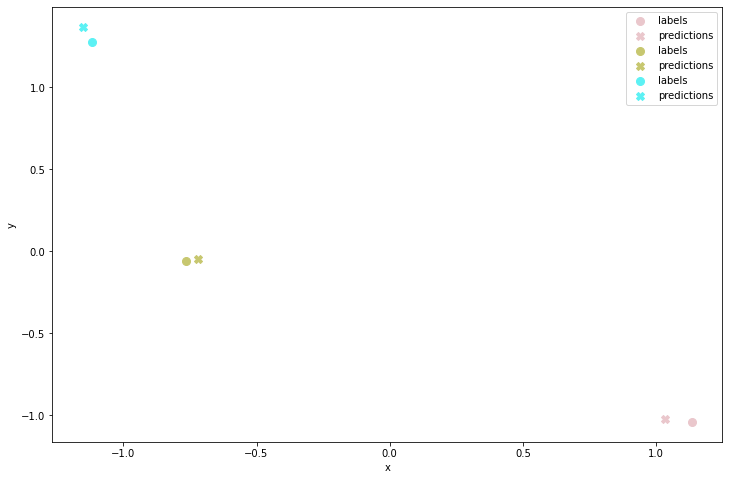

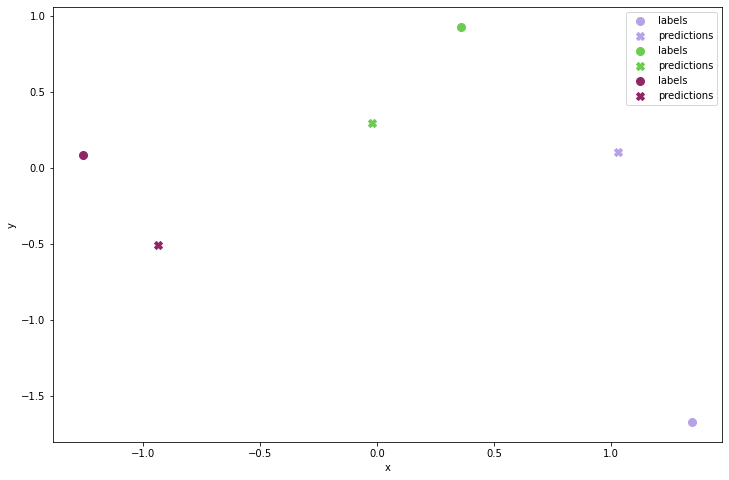

In [ ]:
data_gen.plot(model, max_plots=3, plot_ds='train')
data_gen.plot(model, max_plots=3, plot_ds='val')

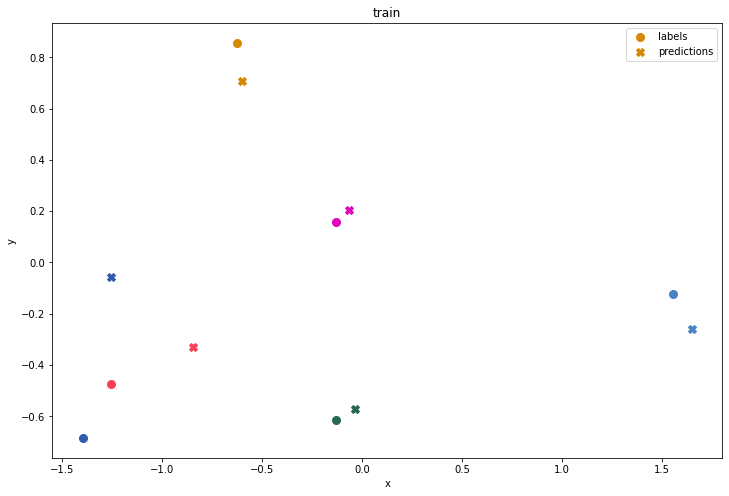

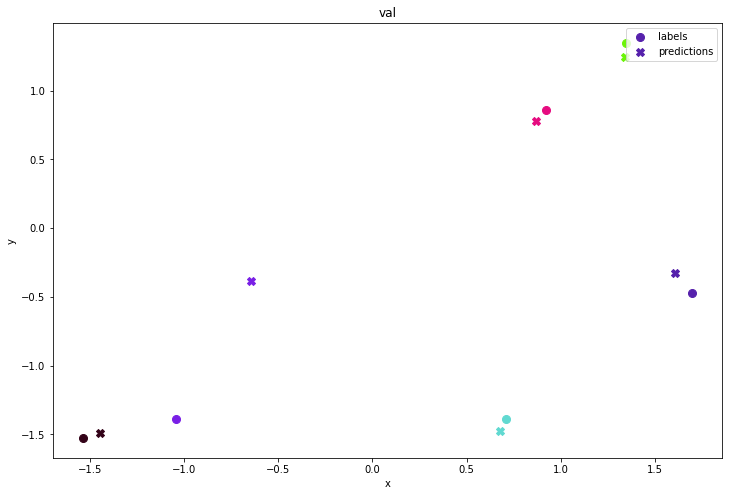

In [ ]:
model = conv1_model
data_gen.plot(model, max_plots=6, plot_ds='train')
data_gen.plot(model, max_plots=6, plot_ds='val')

##### Conv 2

In [ ]:
def conv_block(X, kern_sz, pooling_kern_sz, filters, output_max_pooling=False, kern_l2=0.0):
  # Stage 1
  X = tfl.Conv1D(filters, (kern_sz,), padding='valid', kernel_initializer = tf.keras.initializers.glorot_uniform(),
                                                      kernel_regularizer=tf.keras.regularizers.l2(kern_l2))(X)
  X = tfl.BatchNormalization(axis=-1)(X)
  X = tfl.Activation('relu')(X)
   
  X = tfl.MaxPool1D(pooling_kern_sz,)(X)

  # Stage 2
  X = tfl.Conv1D(filters, (kern_sz,), padding='same', kernel_initializer = tf.keras.initializers.glorot_uniform(),
                                           kernel_regularizer=tf.keras.regularizers.l2(kern_l2))(X)
  X = tfl.BatchNormalization(axis=-1)(X)
  X = tfl.Activation('relu')(X)

  if output_max_pooling:
    X = tfl.MaxPool1D(kern_sz,)(X)

  return X

In [ ]:
def conv2_modelf(input_shape, out_cardinality, kern_l2=0.0):
  assert len(input_shape) == 2
  
  X_input = tfl.Input(input_shape)
  X = X_input

  X = conv_block(X, 7, 3, 96, kern_l2=kern_l2)
  X = conv_block(X, 5, 3, 128, output_max_pooling=True, kern_l2=kern_l2)
  # X = conv_block(X, 3, 1, 384, output_max_pooling=True, kern_l2=kern_l2)
  # X = conv_block(X, 3, 1, 256, output_max_pooling=True, kern_l2=kern_l2)
  
  # Final conv
  X = tfl.Conv1D(128, (3,), padding='same', kernel_initializer = tf.keras.initializers.glorot_uniform(), kernel_regularizer=tf.keras.regularizers.l2(kern_l2))(X)
  X = tfl.BatchNormalization(axis=-1)(X)
  X = tfl.Activation('relu')(X)

  # Final FC‌s
  X = tfl.Flatten()(X)

  X = tfl.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(kern_l2),)(X)
  X = tfl.BatchNormalization()(X)
  X = tfl.Activation('relu')(X)
  X = tfl.Dropout(0.0)(X)

  X = tfl.Dense(out_cardinality, kernel_regularizer=tf.keras.regularizers.l2(kern_l2))(X)

  return tf.keras.Model(inputs=X_input, outputs=X)

In [ ]:
conv2_model = conv2_modelf(vector_shapes[0], out_cardinality, kern_l2=0.00)
conv2_optimizer = tf.keras.optimizers.Adam()


conv2_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5000, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 4994, 96)          768       
                                                                 
 batch_normalization (BatchN  (None, 4994, 96)         384       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 4994, 96)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1664, 96)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1664, 96)          64608 

In [ ]:
# conv2_model.save(os.path.join(BASE_MODELS_PATH, 'conv2'))
# conv1_model = tf.keras.models.load_model(os.path.join(BASE_MODELS_PATH, 'conv1'))

INFO:tensorflow:Assets written to: /content/drive/MyDrive/DL/Acoustic-Source-Detection/models/conv2/assets


In [ ]:
model = conv2_model
history = compile_and_fit(model, data_train=data_gen.train, data_val=data_gen.val,
                          optimizer=conv2_optimizer, lr=1e-3, epochs=40, patience=4)

IPython.display.clear_output()
model.evaluate(data_gen.train)
model.evaluate(data_gen.val)
model.evaluate(data_gen.test)

10/10 [==============================] - 0s 36ms/step - loss: 0.4424 - mean_absolute_error: 0.4880 - r_square: 0.5625


[0.44235530495643616, 0.4880068004131317, 0.5624816417694092]

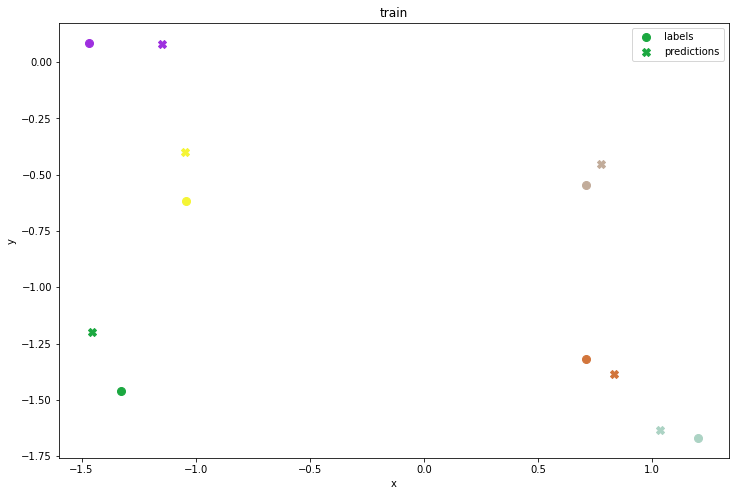

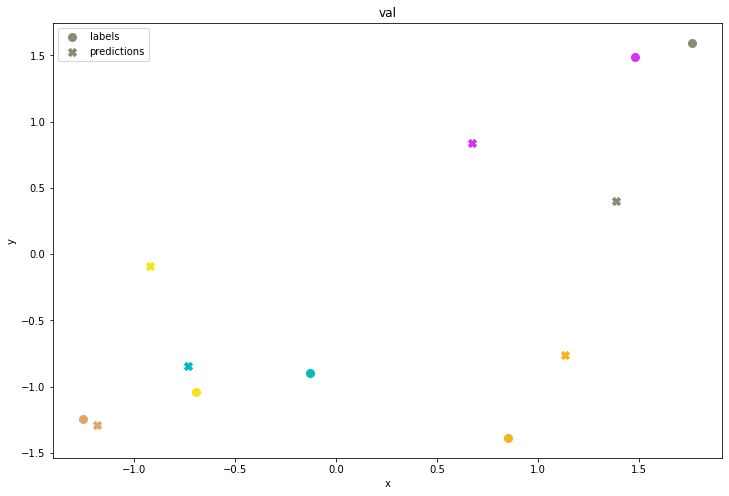

In [ ]:
data_gen.plot(conv2_model, max_plots=6, plot_ds='train')
data_gen.plot(conv2_model, max_plots=6, plot_ds='val')

#### Recurrent


##### LSTM1

In [ ]:
lstm1_model = tf.keras.Sequential([
    tf.keras.layers.Reshape([-1,1], input_shape=vector_shapes[0]),
    # tfl.AveragePooling1D(3),
    # tfl.AveragePooling1D(3),
    tfl.LSTM(256, return_sequences=True),
    tfl.LSTM(128, return_sequences=True),
    tfl.LSTM(64, return_sequences=True),

    tfl.AveragePooling1D(7),
    tfl.AveragePooling1D(5),
    tfl.AveragePooling1D(3),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(1024),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.Dense(128),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.Dense(out_cardinality)
])
lstm1_model.summary()

lstm1_optimizer = tf.keras.optimizers.Adam()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_11 (Reshape)        (None, 5000, 1)           0         
                                                                 
 lstm_33 (LSTM)              (None, 5000, 256)         264192    
                                                                 
 lstm_34 (LSTM)              (None, 5000, 128)         197120    
                                                                 
 lstm_35 (LSTM)              (None, 5000, 64)          49408     
                                                                 
 average_pooling1d_21 (Avera  (None, 714, 64)          0         
 gePooling1D)                                                    
                                                                 
 average_pooling1d_22 (Avera  (None, 142, 64)          0         
 gePooling1D)                                        

In [ ]:
# model1 = model

In [ ]:
model = lstm1_model
history = compile_and_fit(model, data_train=data_gen.train, data_val=data_gen.val,
                          optimizer=lstm1_optimizer, lr=1e-3, patience=3)

IPython.display.clear_output()
model.evaluate(data_gen.train)
model.evaluate(data_gen.val)
model.evaluate(data_gen.test)

Epoch 1/40
294/294 [==============================] - 648s 2s/step - loss: 0.8351 - mean_absolute_error: 0.7233 - r_square: 0.1649 - val_loss: 0.9058 - val_mean_absolute_error: 0.7830 - val_r_square: 0.0846 - lr: 0.0010
Epoch 2/40
294/294 [==============================] - 638s 2s/step - loss: 0.6295 - mean_absolute_error: 0.6236 - r_square: 0.3705 - val_loss: 0.6433 - val_mean_absolute_error: 0.6456 - val_r_square: 0.3514 - lr: 0.0010
Epoch 3/40
294/294 [==============================] - 637s 2s/step - loss: 0.5619 - mean_absolute_error: 0.5811 - r_square: 0.4381 - val_loss: 0.7643 - val_mean_absolute_error: 0.6840 - val_r_square: 0.2303 - lr: 0.0010
Epoch 4/40
294/294 [==============================] - 637s 2s/step - loss: 0.5343 - mean_absolute_error: 0.5652 - r_square: 0.4657 - val_loss: 0.8004 - val_mean_absolute_error: 0.7012 - val_r_square: 0.1935 - lr: 0.0010
Epoch 5/40
294/294 [==============================] - 637s 2s/step - loss: 0.5001 - mean_absolute_error: 0.5426 - r_squa

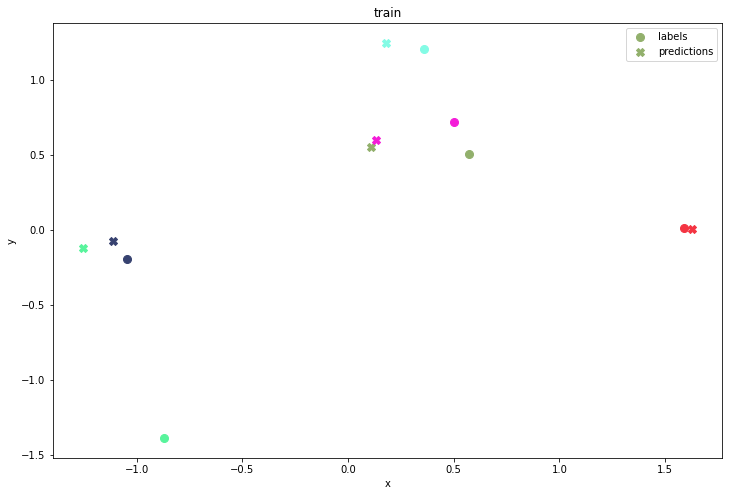

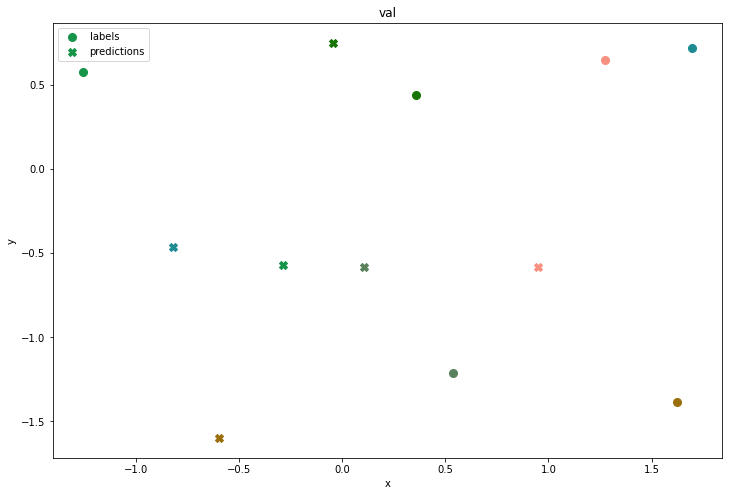

In [ ]:
model = lstm1_model
data_gen.plot(model, max_plots=6, plot_ds='train')
data_gen.plot(model, max_plots=6, plot_ds='val')

In [ ]:
y_pred = lstm_model.predict(X_train_norm)

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(np.arange(len(y_pred)), y_pred[:, 0], y_pred[:, 1], label='pred')
ax.scatter(np.arange(len(Y_train_norm)), Y_train_norm[:, 0], Y_train_norm[:, 1], label='actual')

ax.set_ylim((0,1))
ax.set_zlim((0,1))
ax.legend()

## Merged-FFT Models

In [ ]:
data_gen = DataGenerator(batch_size=32, period=1, map_type=None)

n_features = X_train_norm.shape[1]
out_cardinality = Y_train_norm.shape[1]
vector_shapes = data_gen.vector_shapes

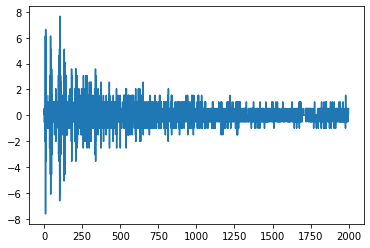

In [ ]:
x, y = next(iter(data_gen.train))
plt.plot(x[0, :, 0])

In [ ]:
def compile_and_fit(model, data_train, data_val, optimizer=tf.keras.optimizers.Adam(), patience=2, lr=0.001, epochs=40):
  early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience*2,
                                                    mode='min')
  reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=patience, mode='auto', min_delta=1e-4)

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=optimizer,
                metrics=[tf.metrics.MeanAbsoluteError(), tfa.metrics.r_square.RSquare(dtype=tf.float32, y_shape=(out_cardinality,))])

  tf.keras.backend.set_value(model.optimizer.learning_rate, lr)

  history = model.fit(data_train, epochs=epochs,
                      validation_data=data_val,
                      callbacks=[reduce])
  return history

### Regression

#### Linear

In [ ]:
def modelf(input_shape, out_cardinality):
  X_input = tfl.Input(input_shape)
  X = X_input

  # X = tfl.AveragePooling1D(3)(X)
  # X = tfl.AveragePooling1D(3)(X)
  # X = tfl.AveragePooling1D(3)(X)
  X = tfl.Flatten()(X)
  
  X = tfl.Dense(32)(X)
  X = tfl.BatchNormalization(axis=-1)(X)
  X = tfl.Activation('relu')(X)
  
  X = tfl.Dense(10)(X)
  X = tfl.BatchNormalization(axis=-1)(X)
  X = tfl.Activation('relu')(X)

  X = tfl.Dense(out_cardinality)(X)
  
  return tf.keras.Model(inputs=X_input, outputs=X)

In [ ]:
linear_model1 = modelf(vector_shapes[0], out_cardinality)
linear1_optimizer = tf.keras.optimizers.Adam()

linear_model1.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 5000, 1)]         0         
                                                                 
 flatten_6 (Flatten)         (None, 5000)              0         
                                                                 
 dense_14 (Dense)            (None, 32)                160032    
                                                                 
 batch_normalization_28 (Bat  (None, 32)               128       
 chNormalization)                                                
                                                                 
 activation_28 (Activation)  (None, 32)                0         
                                                                 
 dense_15 (Dense)            (None, 10)                330       
                                                           

In [ ]:
model = linear_model1
history = compile_and_fit(model, data_train=data_gen.train, data_val=data_gen.val,
                          optimizer=linear1_optimizer, lr=1e-3, patience=4, epochs=200)

IPython.display.clear_output()
model.evaluate(data_gen.train)
model.evaluate(data_gen.val)
model.evaluate(data_gen.test)

3/3 [==============================] - 0s 7ms/step - loss: 0.1354 - mean_absolute_error: 0.3016 - r_square: -0.6577


[0.13543789088726044, 0.3016307055950165, -0.6576828956604004]

In [ ]:
model = linear_model1
history = model.fit(X_train_norm, Y_train_norm, validation_data=(X_val_norm, Y_val_norm), epochs=50, batch_size=32)

IPython.display.clear_output()
model.evaluate(data_gen.train)
model.evaluate(data_gen.val)
model.evaluate(data_gen.test)

Epoch 1/50
69/69 [==============================] - 1s 11ms/step - loss: 0.0091 - mean_absolute_error: 0.0747 - r_square: 0.8948 - val_loss: 0.1379 - val_mean_absolute_error: 0.3062 - val_r_square: -0.5704
Epoch 2/50
69/69 [==============================] - 1s 7ms/step - loss: 0.0095 - mean_absolute_error: 0.0764 - r_square: 0.8907 - val_loss: 0.1381 - val_mean_absolute_error: 0.3064 - val_r_square: -0.5727
Epoch 3/50
69/69 [==============================] - 1s 7ms/step - loss: 0.0091 - mean_absolute_error: 0.0733 - r_square: 0.8945 - val_loss: 0.1378 - val_mean_absolute_error: 0.3060 - val_r_square: -0.5691
Epoch 4/50
69/69 [==============================] - 0s 7ms/step - loss: 0.0079 - mean_absolute_error: 0.0692 - r_square: 0.9085 - val_loss: 0.1380 - val_mean_absolute_error: 0.3062 - val_r_square: -0.5712
Epoch 5/50
69/69 [==============================] - 1s 7ms/step - loss: 0.0081 - mean_absolute_error: 0.0698 - r_square: 0.9067 - val_loss: 0.1379 - val_mean_absolute_error: 0.306

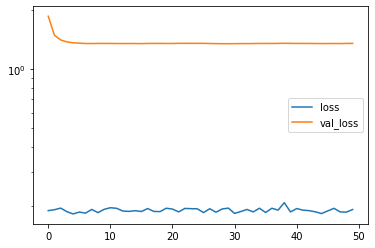

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.yscale('log')

plt.legend()

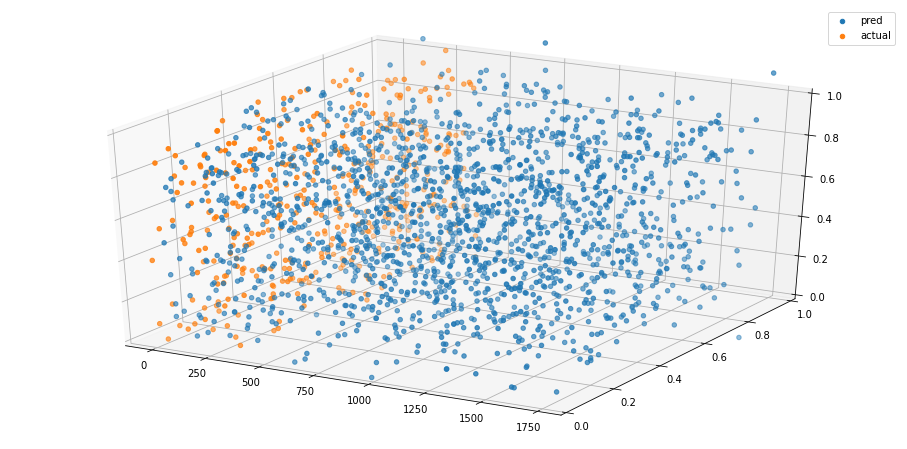

In [ ]:
y_pred = dense_model.predict()

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(np.arange(len(y_pred)), y_pred[:, 0], y_pred[:, 1], label='pred')
ax.scatter(np.arange(len(Y_train_norm)), Y_train_norm[:, 0], Y_train_norm[:, 1], label='actual')

ax.set_ylim((0,1))
ax.set_zlim((0,1))
ax.legend()

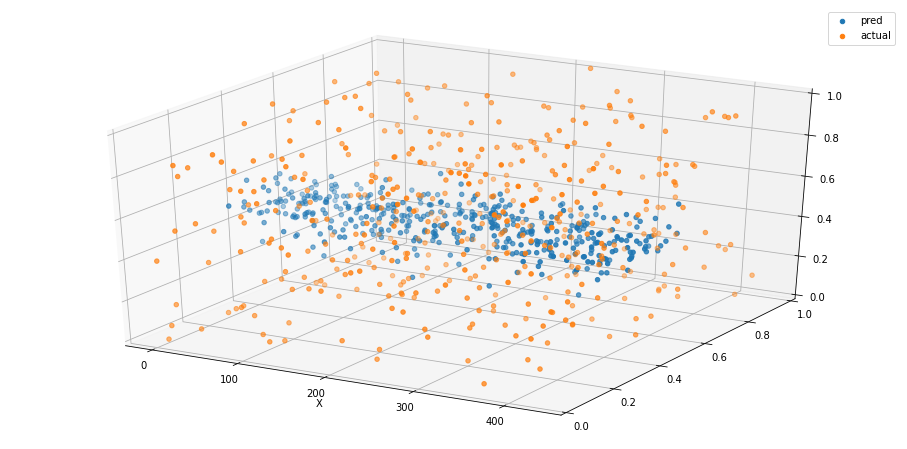

In [ ]:
y_pred = dense_model.predict(X_val_norm)

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(np.arange(len(y_pred)), y_pred[:, 0], y_pred[:, 1], label='pred')
ax.scatter(np.arange(len(Y_val_norm)), Y_val_norm[:, 0], Y_val_norm[:, 1], label='actual')

ax.set_ylim((0,1))
ax.set_zlim((0,1))

ax.set_xlabel('X')
ax.legend()

#### Dense

In [ ]:
def modelf(input_shape):
  X_input = tfl.Input(input_shape)
  X = X_input

  X = tfl.Flatten()(X)
  X = tfl.Dense(10)(X)
  X = tfl.Dense(out_cardinality)(X)
  
  
  return tf.keras.Model(inputs=X_input, outputs=X)

In [ ]:
model = modelf(X_data.shape[1:])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 10000)]           0         
                                                                 
 flatten_2 (Flatten)         (None, 10000)             0         
                                                                 
 dense_4 (Dense)             (None, 10)                100010    
                                                                 
 dense_5 (Dense)             (None, 2)                 22        
                                                                 
Total params: 100,032
Trainable params: 100,032
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = compile_and_fit(model, data_train=data_gen.train, data_val=data_gen.val, lr=0.001, patience=3)

IPython.display.clear_output()
model.evaluate(X_train_norm, Y_train_norm)
model.evaluate(X_val_norm, Y_val_norm)
model.evaluate(X_test_norm, Y_test_norm)

1/1 [==============================] - 0s 35ms/step - loss: 3.7370 - mean_absolute_error: 1.6204 - r_square: -3.9429


[3.737001895904541, 1.62044358253479, -3.942863941192627]

In [ ]:
dense_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 99999, 1)          0         
                                                                 
 conv1d (Conv1D)             (None, 1000, 3)           297003    
                                                                 
 batch_normalization (BatchN  (None, 1000, 3)          12        
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 3000)              0         
                                                                 
 dense (Dense)               (None, 2)                 6002      
                                                                 
Total params: 303,017
Trainable params: 303,011
Non-trainable params: 6
__________________________________________________

In [ ]:
reg_val = 0.001
dense_model = tf.keras.Sequential([
    tfl.Reshape([-1,1]),
    tfl.Conv1D(3, 99900, 1),
    tfl.BatchNormalization(),
    tfl.Flatten(),
    tfl.Dense(out_cardinality)
])

history = compile_and_fit(dense_model, data_train=data_gen.train, data_val=data_gen.val, lr=0.001, patience=3)

IPython.display.clear_output()
dense_model.evaluate(X_train_norm, Y_train_norm)
dense_model.evaluate(X_val_norm, Y_val_norm)
dense_model.evaluate(X_test_norm, Y_test_norm)

In [ ]:
reg_val = 0.001
dense_model = tf.keras.Sequential([
    tfl.Flatten(),
    tfl.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_val), bias_regularizer=tf.keras.regularizers.l2(reg_val)),
    tfl.BatchNormalization(),
    tfl.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_val), bias_regularizer=tf.keras.regularizers.l2(reg_val)),
    tfl.BatchNormalization(),
    tfl.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_val), bias_regularizer=tf.keras.regularizers.l2(reg_val)),
    tfl.BatchNormalization(),
    tfl.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_val), bias_regularizer=tf.keras.regularizers.l2(reg_val)),
    tfl.BatchNormalization(),
    tfl.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_val), bias_regularizer=tf.keras.regularizers.l2(reg_val)),
    tfl.BatchNormalization(),
    tfl.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_val), bias_regularizer=tf.keras.regularizers.l2(reg_val)),
    tfl.BatchNormalization(),
    tfl.Dense(out_cardinality)
])

history = compile_and_fit(dense_model, data_train=data_gen.train, data_val=data_gen.val, lr=0.001, patience=3)

IPython.display.clear_output()
dense_model.evaluate(X_train_norm, Y_train_norm)
dense_model.evaluate(X_val_norm, Y_val_norm)
dense_model.evaluate(X_test_norm, Y_test_norm)

8/8 [==============================] - 0s 18ms/step - loss: 0.4788 - mean_absolute_error: 0.4179 - r_square: -2.0304


[0.4787692725658417, 0.4178805351257324, -2.0304207801818848]

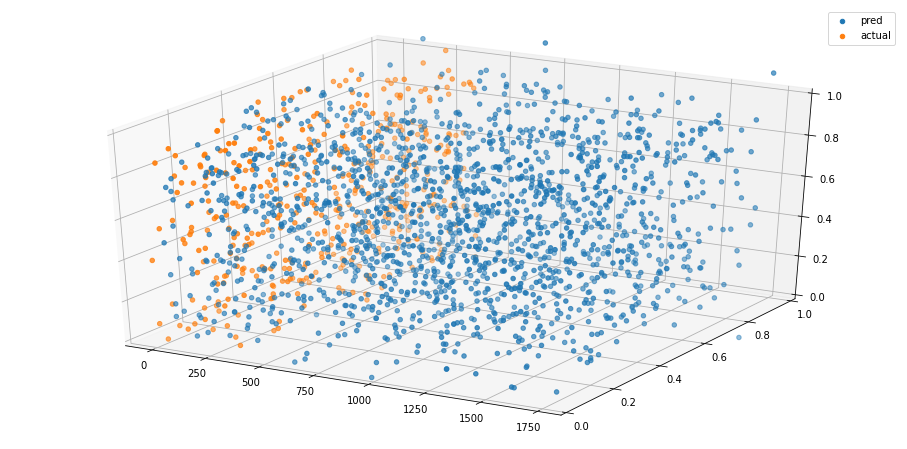

In [ ]:
y_pred = dense_model.predict(X_train_norm)

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(np.arange(len(y_pred)), y_pred[:, 0], y_pred[:, 1], label='pred')
ax.scatter(np.arange(len(Y_train_norm)), Y_train_norm[:, 0], Y_train_norm[:, 1], label='actual')

ax.set_ylim((0,1))
ax.set_zlim((0,1))
ax.legend()

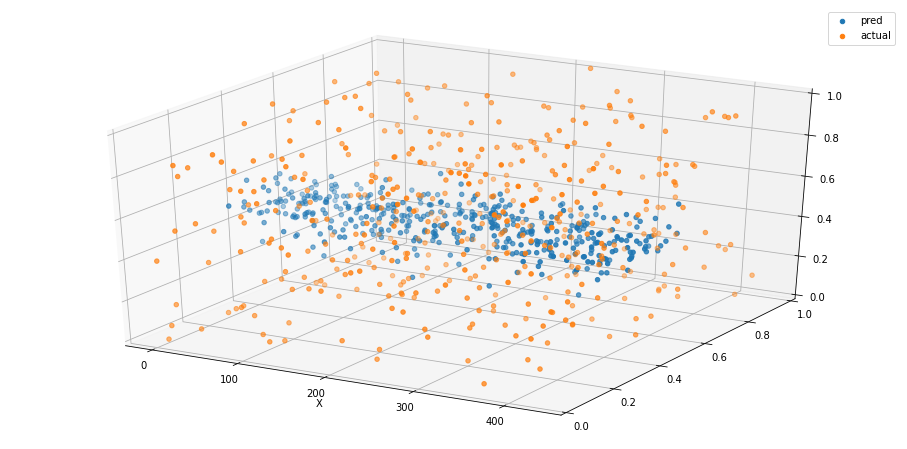

In [ ]:
y_pred = dense_model.predict(X_val_norm)

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(np.arange(len(y_pred)), y_pred[:, 0], y_pred[:, 1], label='pred')
ax.scatter(np.arange(len(Y_val_norm)), Y_val_norm[:, 0], Y_val_norm[:, 1], label='actual')

ax.set_ylim((0,1))
ax.set_zlim((0,1))

ax.set_xlabel('X')
ax.legend()

#### Conv

##### Residual1

In [ ]:
def identity_block(X, filters):
    assert len(filters) == 3

    # Retrieve Filters
    F1, F2, F3 = filters

    # Skip handling
    X_skip = X
    
    # Stage 1
    X = tfl.Conv1D(filters = F1, kernel_size = (1,), strides = (1,), padding = 'valid', kernel_initializer = tf.keras.initializers.glorot_uniform())(X)
    X = tfl.BatchNormalization(axis = 1)(X)
    X = tfl.Activation('relu')(X)
    
    # Stage 2
    X = tfl.Conv1D(filters = F2, kernel_size = (3,), strides = (1,), padding = 'same', kernel_initializer = tf.keras.initializers.glorot_uniform())(X)
    X = tfl.BatchNormalization(axis = 1)(X)
    X = tfl.Activation('relu')(X)
    
    # Stage 3
    X = tfl.Conv1D(filters = F3, kernel_size = (1,), strides = (1,), padding = 'valid', kernel_initializer = tf.keras.initializers.glorot_uniform())(X)
    X = tfl.BatchNormalization(axis = 1)(X)
    
    # Add with skip connection
    X = tfl.Add()([X, X_skip])
    X = tfl.Activation('relu')(X)
    
    return X

In [ ]:
def conv_block(X, filters, s = 2):
    assert len(filters) == 3

    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Skip handling
    X_skip = X
    
    # Stage 1
    X = tfl.Conv1D(filters = F1, kernel_size = (1,), strides = (s,), padding = 'valid', kernel_initializer = tf.keras.initializers.glorot_uniform())(X)
    X = tfl.BatchNormalization(axis = 1)(X)
    X = tfl.Activation('relu')(X)
    
    # Stage 2
    X = tfl.Conv1D(filters = F2, kernel_size = (3,), strides = (1,), padding = 'same', kernel_initializer = tf.keras.initializers.glorot_uniform())(X)
    X = tfl.BatchNormalization(axis = 1)(X)
    X = tfl.Activation('relu')(X)
    
    # Stage 3
    X = tfl.Conv1D(filters = F3, kernel_size = (1,), strides = (1,), padding = 'valid', kernel_initializer = tf.keras.initializers.glorot_uniform())(X)
    X = tfl.BatchNormalization(axis = 1)(X)
    X = tfl.Activation('relu')(X)
    
    # Add with skip connection
    X_skip = tfl.Conv1D(filters = F3, kernel_size = (1,), strides = (s,), padding = 'valid', kernel_initializer = tf.keras.initializers.glorot_uniform())(X_skip)
    X_skip = tfl.BatchNormalization(axis = 1)(X_skip)
    
    X = tfl.Add()([X, X_skip])
    X = tfl.Activation('relu')(X)
    
    return X

In [ ]:
def res_model(input_shape, out_cardinality):
  assert len(input_shape) == 2
  
  X_input = tfl.Input(input_shape)
  X = X_input

  # Initial conv
  X = tfl.Conv1D(64, (7,), strides=5, padding='valid', kernel_initializer = tf.keras.initializers.glorot_uniform())(X)
  X = tfl.BatchNormalization(axis=1)(X)
  X = tfl.Activation('relu')(X)

  # Initial pooling
  X = tfl.MaxPool1D(3, strides=2)(X)

  # Res Level 1
  X = conv_block(X, filters = [64, 64, 256], s = 1)
  X = identity_block(X, [64, 64, 256])
  X = identity_block(X, [64, 64, 256])

  # Res Level 2
  X = conv_block(X, filters = [128, 128, 512], s = 2)
  X = identity_block(X, [128, 128, 512])
  X = identity_block(X, [128, 128, 512])
  X = identity_block(X, [128, 128, 512])

  # Res Level 3
  X = conv_block(X, filters = [256, 256, 1024], s = 2)
  X = identity_block(X, [256, 256, 1024])
  X = identity_block(X, [256, 256, 1024])
  X = identity_block(X, [256, 256, 1024])
  X = identity_block(X, [256, 256, 1024])
  X = identity_block(X, [256, 256, 1024])

  # Res Level 4
  X = conv_block(X, filters = [512, 512, 2048], s = 2)
  X = identity_block(X, [512, 512, 2048])
  X = identity_block(X, [512, 512, 2048])

  # Final layers
  X = tfl.AveragePooling1D(2, strides=1)(X)
  X = tfl.Flatten()(X)
  X = tfl.Dense(out_cardinality)(X)

  return tf.keras.Model(inputs=X_input, outputs=X)

In [ ]:
conv_res_model1 = res_model(vector_shapes[0], out_cardinality)
conv_res_optimizer = tf.keras.optimizers.Adam()

conv_res_model1.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 2000, 1)]    0           []                               
                                                                                                  
 conv1d_62 (Conv1D)             (None, 399, 64)      512         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_63 (BatchN  (None, 399, 64)     1596        ['conv1d_62[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_63 (Activation)     (None, 399, 64)      0           ['batch_normalization_63[0]

In [ ]:
model = conv_res_model1
history = compile_and_fit(model, data_train=data_gen.train, data_val=data_gen.val,
                          optimizer=conv_res_optimizer, lr=1e-4)

IPython.display.clear_output()
model.evaluate(data_gen.train)
model.evaluate(data_gen.val)
model.evaluate(data_gen.test)

Epoch 1/40
285/285 [==============================] - 87s 268ms/step - loss: 0.0615 - mean_absolute_error: 0.1920 - r_square: 0.9385 - val_loss: 0.5900 - val_mean_absolute_error: 0.5666 - val_r_square: 0.3783 - lr: 1.0000e-04
Epoch 2/40
285/285 [==============================] - 74s 259ms/step - loss: 0.0586 - mean_absolute_error: 0.1894 - r_square: 0.9414 - val_loss: 0.5525 - val_mean_absolute_error: 0.5513 - val_r_square: 0.4180 - lr: 1.0000e-04
Epoch 3/40
285/285 [==============================] - 74s 259ms/step - loss: 0.0577 - mean_absolute_error: 0.1866 - r_square: 0.9423 - val_loss: 0.5630 - val_mean_absolute_error: 0.5558 - val_r_square: 0.4068 - lr: 1.0000e-04
Epoch 4/40
285/285 [==============================] - 74s 258ms/step - loss: 0.0574 - mean_absolute_error: 0.1863 - r_square: 0.9426 - val_loss: 0.5712 - val_mean_absolute_error: 0.5600 - val_r_square: 0.3987 - lr: 1.0000e-04
Epoch 5/40
 44/285 [===>..........................] - ETA: 1:01 - loss: 0.0602 - mean_absolute_e

KeyboardInterrupt: ignored

##### Residual2

In [ ]:
def identity_block(X, filters):
    assert len(filters) == 3

    # Retrieve Filters
    F1, F2, F3 = filters

    # Skip handling
    X_skip = X
    
    # Stage 1
    X = tfl.Conv1D(filters = F1, kernel_size = (1,), strides = (1,), padding = 'valid', kernel_initializer = tf.keras.initializers.glorot_uniform())(X)
    X = tfl.BatchNormalization(axis = 1)(X)
    X = tfl.Activation('relu')(X)
    
    # Stage 2
    X = tfl.Conv1D(filters = F2, kernel_size = (3,), strides = (1,), padding = 'same', kernel_initializer = tf.keras.initializers.glorot_uniform())(X)
    X = tfl.BatchNormalization(axis = 1)(X)
    X = tfl.Activation('relu')(X)
    
    # Stage 3
    X = tfl.Conv1D(filters = F3, kernel_size = (1,), strides = (1,), padding = 'valid', kernel_initializer = tf.keras.initializers.glorot_uniform())(X)
    X = tfl.BatchNormalization(axis = 1)(X)
    
    # Add with skip connection
    X = tfl.Add()([X, X_skip])
    X = tfl.Activation('relu')(X)
    
    return X

In [ ]:
def conv_block(X, filters, s = 2):
    assert len(filters) == 3

    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Skip handling
    X_skip = X
    
    # Stage 1
    X = tfl.Conv1D(filters = F1, kernel_size = (1,), strides = (s,), padding = 'valid', kernel_initializer = tf.keras.initializers.glorot_uniform())(X)
    X = tfl.BatchNormalization(axis = 1)(X)
    X = tfl.Activation('relu')(X)
    
    # Stage 2
    X = tfl.Conv1D(filters = F2, kernel_size = (3,), strides = (1,), padding = 'same', kernel_initializer = tf.keras.initializers.glorot_uniform())(X)
    X = tfl.BatchNormalization(axis = 1)(X)
    X = tfl.Activation('relu')(X)
    
    # Stage 3
    X = tfl.Conv1D(filters = F3, kernel_size = (1,), strides = (1,), padding = 'valid', kernel_initializer = tf.keras.initializers.glorot_uniform())(X)
    X = tfl.BatchNormalization(axis = 1)(X)
    X = tfl.Activation('relu')(X)
    
    # Add with skip connection
    X_skip = tfl.Conv1D(filters = F3, kernel_size = (1,), strides = (s,), padding = 'valid', kernel_initializer = tf.keras.initializers.glorot_uniform())(X_skip)
    X_skip = tfl.BatchNormalization(axis = 1)(X_skip)
    
    X = tfl.Add()([X, X_skip])
    X = tfl.Activation('relu')(X)
    
    return X

In [ ]:
def conv_res_modelf2(input_shape, out_cardinality):
  assert len(input_shape) == 2
  
  X_input = tfl.Input(input_shape)
  X = X_input

  # Initial conv
  X = tfl.Conv1D(64, (7,), strides=5, padding='valid', kernel_initializer = tf.keras.initializers.glorot_uniform())(X)
  X = tfl.BatchNormalization(axis=1)(X)
  X = tfl.Activation('relu')(X)

  # Initial pooling
  X = tfl.MaxPool1D(3, strides=2)(X)

  # Res Level 1
  X = conv_block(X, filters = [64, 64, 256], s = 1)
  X = identity_block(X, [64, 64, 256])

  # Res Level 2
  X = conv_block(X, filters = [128, 128, 512], s = 2)
  X = identity_block(X, [128, 128, 512])

  # Res Level 3
  X = conv_block(X, filters = [256, 256, 1024], s = 2)

  # Res Level 4
  X = conv_block(X, filters = [512, 512, 1024], s = 2)

  # Final layers
  X = tfl.AveragePooling1D(2, strides=1)(X)
  X = tfl.Flatten()(X)
  X = tfl.Dense(out_cardinality)(X)

  return tf.keras.Model(inputs=X_input, outputs=X)

In [ ]:
conv_res_model2 = conv_res_modelf2(vector_shapes[0], out_cardinality)
conv_res_optimizer2 = tf.keras.optimizers.Adam()

conv_res_model2.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 10000, 1)]   0           []                               
                                                                                                  
 conv1d_261 (Conv1D)            (None, 1999, 64)     512         ['input_13[0][0]']               
                                                                                                  
 batch_normalization_265 (Batch  (None, 1999, 64)    7996        ['conv1d_261[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_265 (Activation)    (None, 1999, 64)     0           ['batch_normalization_265[

In [ ]:
model = conv_res_model2
history = compile_and_fit(model, data_train=data_gen.train, data_val=data_gen.val,
                          optimizer=conv_res_optimizer2, lr=1e-4)

IPython.display.clear_output()
model.evaluate(data_gen.train)
model.evaluate(data_gen.val)
model.evaluate(data_gen.test)

Epoch 1/40
51/51 [==============================] - 72s 753ms/step - loss: 6.9267 - mean_absolute_error: 1.5030 - r_square: -78.6753 - val_loss: 0.3038 - val_mean_absolute_error: 0.4703 - val_r_square: -2.6289 - lr: 1.0000e-04
Epoch 2/40
51/51 [==============================] - 35s 677ms/step - loss: 0.0994 - mean_absolute_error: 0.2682 - r_square: -0.1432 - val_loss: 0.2951 - val_mean_absolute_error: 0.4618 - val_r_square: -2.5296 - lr: 1.0000e-04
Epoch 3/40
51/51 [==============================] - 35s 680ms/step - loss: 0.0913 - mean_absolute_error: 0.2600 - r_square: -0.0500 - val_loss: 0.2776 - val_mean_absolute_error: 0.4442 - val_r_square: -2.3159 - lr: 1.0000e-04
Epoch 4/40
51/51 [==============================] - 35s 680ms/step - loss: 0.0930 - mean_absolute_error: 0.2614 - r_square: -0.0685 - val_loss: 0.2200 - val_mean_absolute_error: 0.3856 - val_r_square: -1.6091 - lr: 1.0000e-04
Epoch 5/40
51/51 [==============================] - 35s 682ms/step - loss: 0.0977 - mean_absolu

KeyboardInterrupt: ignored

##### Conv 1
J. M. Vera-Diaz, D. Pizarro, and J. Macias-Guarasa, “Towards endto-end acoustic localization using deep learning: from audio signal to source position coordinates,” Sensors, vol. 18, no. 10, p. 3418, 2018.

In [ ]:
def conv_block(X, kern_sz, pooling_kern_sz, filters, output_max_pooling=False):
  # Stage 1
  X = tfl.Conv1D(filters, (kern_sz,), padding='valid', kernel_initializer = tf.keras.initializers.glorot_uniform())(X)
  X = tfl.BatchNormalization(axis=-1)(X)
  X = tfl.Activation('relu')(X)

  X = tfl.MaxPool1D(pooling_kern_sz,)(X)

  # Stage 2
  X = tfl.Conv1D(filters, (kern_sz,), padding='same', kernel_initializer = tf.keras.initializers.glorot_uniform())(X)
  X = tfl.BatchNormalization(axis=-1)(X)
  X = tfl.Activation('relu')(X)

  if output_max_pooling:
    X = tfl.MaxPool1D(kern_sz,)(X)

  return X

In [ ]:
def conv1_modelf(input_shape, out_cardinality):
  assert len(input_shape) == 2
  
  X_input = tfl.Input(input_shape)
  X = X_input

  X = conv_block(X, 7, 3, 96)
  X = conv_block(X, 5, 3, 128, output_max_pooling=True)
  
  # Final conv
  X = tfl.Conv1D(128, (3,), padding='same', kernel_initializer = tf.keras.initializers.glorot_uniform())(X)
  X = tfl.BatchNormalization(axis=-1)(X)
  X = tfl.Activation('relu')(X)

  # Final FC‌s
  X = tfl.Flatten()(X)

  X = tfl.Dense(128,)(X)
  X = tfl.BatchNormalization()(X)
  X = tfl.Activation('relu')(X)
  X = tfl.Dropout(0.5)(X)

  X = tfl.Dense(out_cardinality)(X)

  return tf.keras.Model(inputs=X_input, outputs=X)

In [ ]:
conv1_model = conv1_modelf(vector_shapes[0], out_cardinality)
optimizer = tf.keras.optimizers.Adam()

conv1_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10000, 1)]        0         
                                                                 
 conv1d_5 (Conv1D)           (None, 9994, 96)          768       
                                                                 
 batch_normalization_6 (Batc  (None, 9994, 96)         384       
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 9994, 96)          0         
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 3331, 96)         0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 3331, 96)          6460

In [ ]:
model = conv1_model
history = compile_and_fit(model, data_train=data_gen.train, data_val=data_gen.val,
                          optimizer=optimizer, lr=1e-5, patience=10)

IPython.display.clear_output()
model.evaluate(data_gen.train)
model.evaluate(data_gen.val)
model.evaluate(data_gen.test)

1/1 [==============================] - 0s 58ms/step - loss: 0.5633 - mean_absolute_error: 0.6129 - r_square: 0.3283


[0.5633052587509155, 0.612892746925354, 0.3283454179763794]

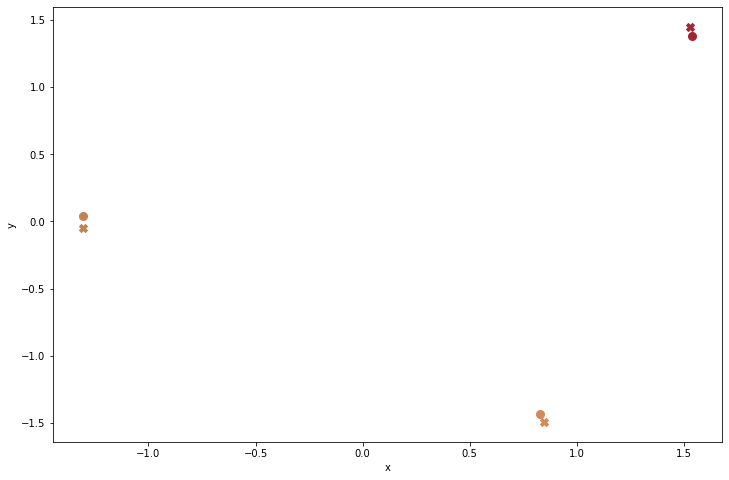

In [ ]:
data_gen.plot(conv2_model, max_plots=3, plot_ds='train')

##### Conv 2

In [ ]:
def conv_block(X, kern_sz, pooling_kern_sz, filters, output_max_pooling=False, kern_l2=0.0):
  # Stage 1
  X = tfl.Conv1D(filters, (kern_sz,), padding='valid', kernel_initializer = tf.keras.initializers.glorot_uniform(),
                                                      kernel_regularizer=tf.keras.regularizers.l2(kern_l2))(X)
  X = tfl.BatchNormalization(axis=-1)(X)
  X = tfl.Activation('relu')(X)
   
  X = tfl.MaxPool1D(pooling_kern_sz,)(X)

  # Stage 2
  X = tfl.Conv1D(filters, (kern_sz,), padding='same', kernel_initializer = tf.keras.initializers.glorot_uniform(),
                                           kernel_regularizer=tf.keras.regularizers.l2(kern_l2))(X)
  X = tfl.BatchNormalization(axis=-1)(X)
  X = tfl.Activation('relu')(X)

  if output_max_pooling:
    X = tfl.MaxPool1D(kern_sz,)(X)

  return X

In [ ]:
def conv2_modelf(input_shape, out_cardinality, kern_l2=0.0):
  assert len(input_shape) == 2
  
  X_input = tfl.Input(input_shape)
  X = X_input

  X = conv_block(X, 7, 3, 96, kern_l2=kern_l2)
  X = conv_block(X, 5, 3, 128, output_max_pooling=True, kern_l2=kern_l2)
  # X = conv_block(X, 3, 1, 384, output_max_pooling=True, kern_l2=kern_l2)
  # X = conv_block(X, 3, 1, 256, output_max_pooling=True, kern_l2=kern_l2)
  
  # Final conv
  X = tfl.Conv1D(128, (3,), padding='same', kernel_initializer = tf.keras.initializers.glorot_uniform(), kernel_regularizer=tf.keras.regularizers.l2(kern_l2))(X)
  X = tfl.BatchNormalization(axis=-1)(X)
  X = tfl.Activation('relu')(X)
  X = tfl.Dropout(0.0)(X)

  # Final FC‌s
  X = tfl.Flatten()(X)

  X = tfl.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(kern_l2),)(X)
  X = tfl.BatchNormalization()(X)
  X = tfl.Activation('relu')(X)
  X = tfl.Dropout(0.0)(X)

  X = tfl.Dense(out_cardinality, kernel_regularizer=tf.keras.regularizers.l2(kern_l2))(X)

  return tf.keras.Model(inputs=X_input, outputs=X)

In [ ]:
conv2_model = conv2_modelf(vector_shapes[0], out_cardinality, kern_l2=0.01)
conv2_optimizer = tf.keras.optimizers.Adam()


conv2_model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 2750, 1)]         0         
                                                                 
 conv1d_42 (Conv1D)          (None, 2744, 96)          768       
                                                                 
 batch_normalization_50 (Bat  (None, 2744, 96)         384       
 chNormalization)                                                
                                                                 
 activation_50 (Activation)  (None, 2744, 96)          0         
                                                                 
 max_pooling1d_26 (MaxPoolin  (None, 914, 96)          0         
 g1D)                                                            
                                                                 
 conv1d_43 (Conv1D)          (None, 914, 96)           6460

In [ ]:
# conv2_model.save_weights('/content/tmp_weights')
# conv2_model.load_weights('/content/tmp_weights')

In [ ]:
model = conv2_model
history = compile_and_fit(model, data_train=data_gen.train, data_val=data_gen.val,
                          optimizer=conv2_optimizer, lr=1e-3, epochs=100, patience=4)

IPython.display.clear_output()
model.evaluate(data_gen.train)
model.evaluate(data_gen.val)
model.evaluate(data_gen.test)

Epoch 1/100
285/285 [==============================] - 28s 83ms/step - loss: 8.1165 - mean_absolute_error: 0.6718 - r_square: 0.2770 - val_loss: 3.9091 - val_mean_absolute_error: 0.8303 - val_r_square: 0.0838 - lr: 0.0010
Epoch 2/100
285/285 [==============================] - 23s 80ms/step - loss: 2.2526 - mean_absolute_error: 0.6378 - r_square: 0.3498 - val_loss: 1.6115 - val_mean_absolute_error: 0.7542 - val_r_square: 0.1973 - lr: 0.0010
Epoch 3/100
285/285 [==============================] - 23s 81ms/step - loss: 1.1739 - mean_absolute_error: 0.6314 - r_square: 0.3592 - val_loss: 1.1652 - val_mean_absolute_error: 0.7362 - val_r_square: 0.2156 - lr: 0.0010
Epoch 4/100
285/285 [==============================] - 23s 80ms/step - loss: 0.9574 - mean_absolute_error: 0.6344 - r_square: 0.3541 - val_loss: 1.4004 - val_mean_absolute_error: 0.8231 - val_r_square: -0.1201 - lr: 0.0010
Epoch 5/100
285/285 [==============================] - 23s 80ms/step - loss: 0.8919 - mean_absolute_error: 0.63

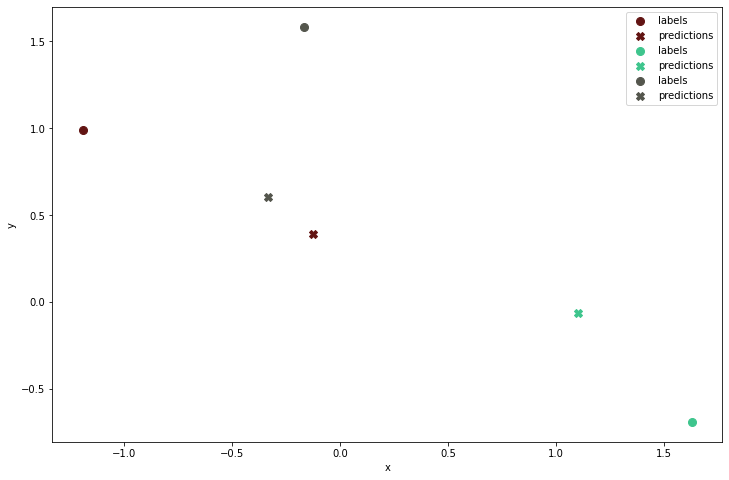

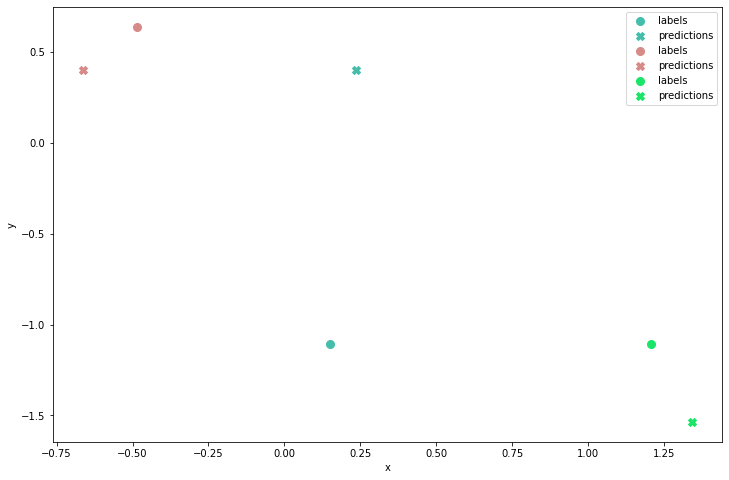

In [ ]:
data_gen.plot(conv2_model, max_plots=3, plot_ds='train')
data_gen.plot(conv2_model, max_plots=3, plot_ds='val')

#### Recurrent


##### LSTM1

In [ ]:
lstm1_model = tf.keras.Sequential([
    tf.keras.layers.Reshape([-1,1], input_shape=vector_shapes[0]),
    tfl.AveragePooling1D(3),
    tfl.AveragePooling1D(3),
    tfl.LSTM(64, return_sequences=True),
    tfl.LSTM(64, return_sequences=True),
    # tfl.LSTM(64, return_sequences=True),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(out_cardinality)
])
lstm1_model.summary()

lstm1_optimizer = tf.keras.optimizers.Adam()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_7 (Reshape)         (None, 6875, 1)           0         
                                                                 
 average_pooling1d_5 (Averag  (None, 2291, 1)          0         
 ePooling1D)                                                     
                                                                 
 average_pooling1d_6 (Averag  (None, 763, 1)           0         
 ePooling1D)                                                     
                                                                 
 lstm_9 (LSTM)               (None, 763, 64)           16896     
                                                                 
 lstm_10 (LSTM)              (None, 763, 64)           33024     
                                                                 
 flatten_12 (Flatten)        (None, 48832)            

In [ ]:
# model1 = model

In [ ]:
model = lstm1_model
history = compile_and_fit(model, data_train=data_gen.train, data_val=data_gen.val,
                          optimizer=lstm1_optimizer, lr=1e-4)

IPython.display.clear_output()
model.evaluate(data_gen.train)
model.evaluate(data_gen.val)
model.evaluate(data_gen.test)

Epoch 1/40
237/237 [==============================] - 133s 261ms/step - loss: 0.4719 - mean_absolute_error: 0.5322 - r_square: 0.5281 - val_loss: 0.6789 - val_mean_absolute_error: 0.6420 - val_r_square: 0.2895 - lr: 1.0000e-04
Epoch 2/40
237/237 [==============================] - 59s 249ms/step - loss: 0.4660 - mean_absolute_error: 0.5291 - r_square: 0.5340 - val_loss: 0.6761 - val_mean_absolute_error: 0.6417 - val_r_square: 0.2925 - lr: 1.0000e-04
Epoch 3/40
237/237 [==============================] - 55s 230ms/step - loss: 0.4626 - mean_absolute_error: 0.5275 - r_square: 0.5373 - val_loss: 0.6795 - val_mean_absolute_error: 0.6426 - val_r_square: 0.2890 - lr: 1.0000e-04
Epoch 4/40
237/237 [==============================] - 58s 244ms/step - loss: 0.4596 - mean_absolute_error: 0.5257 - r_square: 0.5404 - val_loss: 0.6887 - val_mean_absolute_error: 0.6487 - val_r_square: 0.2794 - lr: 1.0000e-04
Epoch 5/40
237/237 [==============================] - 50s 211ms/step - loss: 0.4562 - mean_abso

In [ ]:
y_pred = lstm_model.predict(X_train_norm)

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(np.arange(len(y_pred)), y_pred[:, 0], y_pred[:, 1], label='pred')
ax.scatter(np.arange(len(Y_train_norm)), Y_train_norm[:, 0], Y_train_norm[:, 1], label='actual')

ax.set_ylim((0,1))
ax.set_zlim((0,1))
ax.legend()

## FFT Models

In [ ]:
data_gen = DataGenerator(batch_size=32, period=1, map_type='fft')

n_features = X_train_norm.shape[1]
out_cardinality = Y_train_norm.shape[1]
vector_shapes = data_gen.vector_shapes

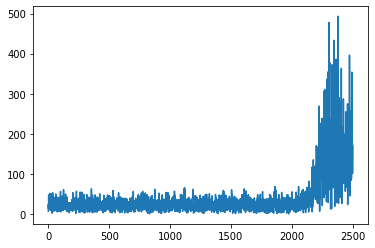

In [ ]:
x, y = next(iter(data_gen.val))
plt.plot(x[0, :, 0])

In [ ]:
def compile_and_fit(model, data_train, data_val, optimizer=tf.keras.optimizers.Adam(), patience=2, lr=0.001, epochs=40):
  early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience*2,
                                                    mode='min')
  reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=patience, mode='auto')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=optimizer,
                metrics=[tf.metrics.MeanAbsoluteError(), tfa.metrics.r_square.RSquare(dtype=tf.float32, y_shape=(out_cardinality,))])

  tf.keras.backend.set_value(model.optimizer.learning_rate, lr)

  history = model.fit(data_train, epochs=epochs,
                      validation_data=data_val,
                      callbacks=[reduce])
  return history

### Regression

#### Dense

In [ ]:
def modelf(input_shape, out_cardinality):
  X_input = tfl.Input(input_shape)
  X = X_input

  X = tfl.AveragePooling1D(3)(X)
  X = tfl.AveragePooling1D(3)(X)
  X = tfl.AveragePooling1D(3)(X)
  X = tfl.Flatten()(X)
  
  X = tfl.Dense(10)(X)
  X = tfl.BatchNormalization(axis=-1)(X)
  X = tfl.Activation('relu')(X)

  X = tfl.Dense(out_cardinality)(X)
  
  return tf.keras.Model(inputs=X_input, outputs=X)

In [ ]:
linear_model1 = modelf(vector_shapes[0], out_cardinality)
linear1_optimizer = tf.keras.optimizers.Adam()

linear_model1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5000, 1)]         0         
                                                                 
 average_pooling1d_3 (Averag  (None, 1666, 1)          0         
 ePooling1D)                                                     
                                                                 
 average_pooling1d_4 (Averag  (None, 555, 1)           0         
 ePooling1D)                                                     
                                                                 
 average_pooling1d_5 (Averag  (None, 185, 1)           0         
 ePooling1D)                                                     
                                                                 
 flatten_1 (Flatten)         (None, 185)               0         
                                                           

In [ ]:
model = linear_model1
history = compile_and_fit(model, data_train=data_gen.train, data_val=data_gen.val,
                          optimizer=linear1_optimizer, lr=1e-3, patience=6, epochs=200)

IPython.display.clear_output()
model.evaluate(data_gen.train)
model.evaluate(data_gen.val)
model.evaluate(data_gen.test)

1/1 [==============================] - 1s 799ms/step - loss: 1.2602 - mean_absolute_error: 0.9652 - r_square: -0.2260


[1.2602108716964722, 0.9651562571525574, -0.22602158784866333]

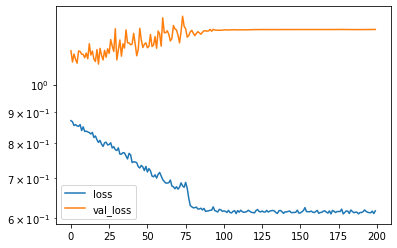

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.yscale('log')

plt.legend()

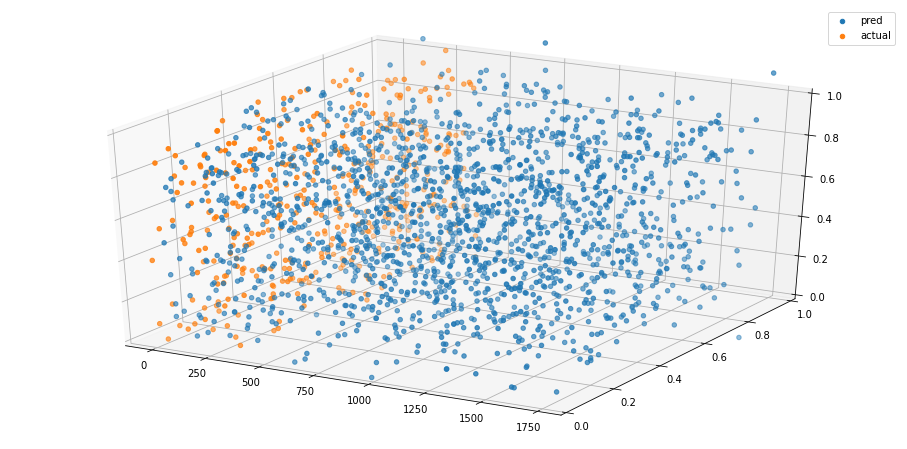

In [ ]:
y_pred = dense_model.predict()

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(np.arange(len(y_pred)), y_pred[:, 0], y_pred[:, 1], label='pred')
ax.scatter(np.arange(len(Y_train_norm)), Y_train_norm[:, 0], Y_train_norm[:, 1], label='actual')

ax.set_ylim((0,1))
ax.set_zlim((0,1))
ax.legend()

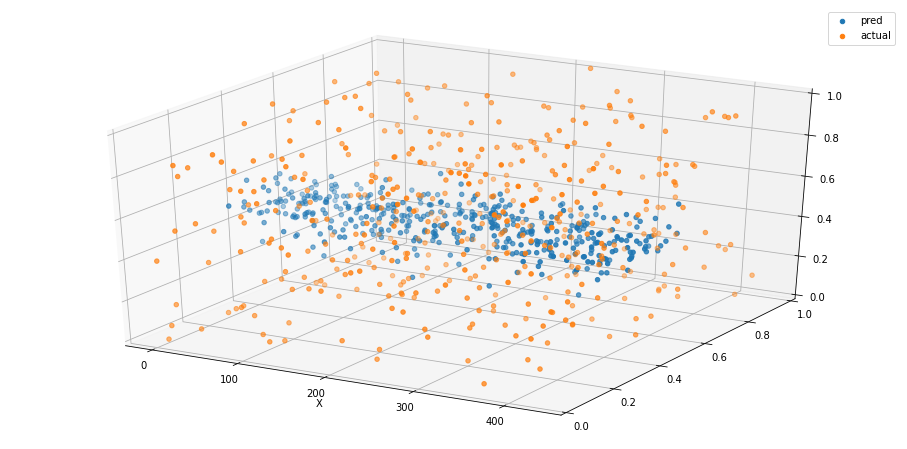

In [ ]:
y_pred = dense_model.predict(X_val_norm)

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(np.arange(len(y_pred)), y_pred[:, 0], y_pred[:, 1], label='pred')
ax.scatter(np.arange(len(Y_val_norm)), Y_val_norm[:, 0], Y_val_norm[:, 1], label='actual')

ax.set_ylim((0,1))
ax.set_zlim((0,1))

ax.set_xlabel('X')
ax.legend()

#### Conv

##### Residual1

In [ ]:
def identity_block(X, filters):
    assert len(filters) == 3

    # Retrieve Filters
    F1, F2, F3 = filters

    # Skip handling
    X_skip = X
    
    # Stage 1
    X = tfl.Conv1D(filters = F1, kernel_size = (1,), strides = (1,), padding = 'valid', kernel_initializer = tf.keras.initializers.glorot_uniform())(X)
    X = tfl.BatchNormalization(axis = 1)(X)
    X = tfl.Activation('relu')(X)
    
    # Stage 2
    X = tfl.Conv1D(filters = F2, kernel_size = (3,), strides = (1,), padding = 'same', kernel_initializer = tf.keras.initializers.glorot_uniform())(X)
    X = tfl.BatchNormalization(axis = 1)(X)
    X = tfl.Activation('relu')(X)
    
    # Stage 3
    X = tfl.Conv1D(filters = F3, kernel_size = (1,), strides = (1,), padding = 'valid', kernel_initializer = tf.keras.initializers.glorot_uniform())(X)
    X = tfl.BatchNormalization(axis = 1)(X)
    
    # Add with skip connection
    X = tfl.Add()([X, X_skip])
    X = tfl.Activation('relu')(X)
    
    return X

In [ ]:
def conv_block(X, filters, s = 2):
    assert len(filters) == 3

    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Skip handling
    X_skip = X
    
    # Stage 1
    X = tfl.Conv1D(filters = F1, kernel_size = (1,), strides = (s,), padding = 'valid', kernel_initializer = tf.keras.initializers.glorot_uniform())(X)
    X = tfl.BatchNormalization(axis = 1)(X)
    X = tfl.Activation('relu')(X)
    
    # Stage 2
    X = tfl.Conv1D(filters = F2, kernel_size = (3,), strides = (1,), padding = 'same', kernel_initializer = tf.keras.initializers.glorot_uniform())(X)
    X = tfl.BatchNormalization(axis = 1)(X)
    X = tfl.Activation('relu')(X)
    
    # Stage 3
    X = tfl.Conv1D(filters = F3, kernel_size = (1,), strides = (1,), padding = 'valid', kernel_initializer = tf.keras.initializers.glorot_uniform())(X)
    X = tfl.BatchNormalization(axis = 1)(X)
    X = tfl.Activation('relu')(X)
    
    # Add with skip connection
    X_skip = tfl.Conv1D(filters = F3, kernel_size = (1,), strides = (s,), padding = 'valid', kernel_initializer = tf.keras.initializers.glorot_uniform())(X_skip)
    X_skip = tfl.BatchNormalization(axis = 1)(X_skip)
    
    X = tfl.Add()([X, X_skip])
    X = tfl.Activation('relu')(X)
    
    return X

In [ ]:
def res_model(input_shape, out_cardinality):
  assert len(input_shape) == 2
  
  X_input = tfl.Input(input_shape)
  X = X_input

  # Initial conv
  X = tfl.Conv1D(64, (7,), strides=5, padding='valid', kernel_initializer = tf.keras.initializers.glorot_uniform())(X)
  X = tfl.BatchNormalization(axis=1)(X)
  X = tfl.Activation('relu')(X)

  # Initial pooling
  X = tfl.MaxPool1D(3, strides=2)(X)

  # Res Level 1
  X = conv_block(X, filters = [64, 64, 256], s = 1)
  X = identity_block(X, [64, 64, 256])
  X = identity_block(X, [64, 64, 256])

  # Res Level 2
  X = conv_block(X, filters = [128, 128, 512], s = 2)
  X = identity_block(X, [128, 128, 512])
  X = identity_block(X, [128, 128, 512])
  X = identity_block(X, [128, 128, 512])

  # Res Level 3
  X = conv_block(X, filters = [256, 256, 1024], s = 2)
  X = identity_block(X, [256, 256, 1024])
  X = identity_block(X, [256, 256, 1024])
  X = identity_block(X, [256, 256, 1024])
  X = identity_block(X, [256, 256, 1024])
  X = identity_block(X, [256, 256, 1024])

  # Res Level 4
  X = conv_block(X, filters = [512, 512, 2048], s = 2)
  X = identity_block(X, [512, 512, 2048])
  X = identity_block(X, [512, 512, 2048])

  # Final layers
  X = tfl.AveragePooling1D(2, strides=1)(X)
  X = tfl.Flatten()(X)
  X = tfl.Dense(out_cardinality)(X)

  return tf.keras.Model(inputs=X_input, outputs=X)

In [ ]:
conv_res_model1 = res_model(vector_shapes[0], out_cardinality)
conv_res_optimizer = tf.keras.optimizers.Adam()

conv_res_model1.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 10000, 1)]   0           []                               
                                                                                                  
 conv1d_68 (Conv1D)             (None, 1999, 64)     512         ['input_5[0][0]']                
                                                                                                  
 batch_normalization_71 (BatchN  (None, 1999, 64)    7996        ['conv1d_68[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_71 (Activation)     (None, 1999, 64)     0           ['batch_normalization_71[0]

In [ ]:
model = conv_res_model1
history = compile_and_fit(model, data_train=data_gen.train, data_val=data_gen.val,
                          optimizer=conv_res_optimizer, lr=5e-3)

IPython.display.clear_output()
model.evaluate(data_gen.train)
model.evaluate(data_gen.val)
model.evaluate(data_gen.test)

Epoch 1/40
 31/102 [========>.....................] - ETA: 2:15 - loss: 120033.8438 - mean_absolute_error: 127.1455 - r_square: -1385511.2500

KeyboardInterrupt: ignored

##### Residual2

In [ ]:
def identity_block(X, filters):
    assert len(filters) == 3

    # Retrieve Filters
    F1, F2, F3 = filters

    # Skip handling
    X_skip = X
    
    # Stage 1
    X = tfl.Conv1D(filters = F1, kernel_size = (1,), strides = (1,), padding = 'valid', kernel_initializer = tf.keras.initializers.glorot_uniform())(X)
    X = tfl.BatchNormalization(axis = 1)(X)
    X = tfl.Activation('relu')(X)
    
    # Stage 2
    X = tfl.Conv1D(filters = F2, kernel_size = (3,), strides = (1,), padding = 'same', kernel_initializer = tf.keras.initializers.glorot_uniform())(X)
    X = tfl.BatchNormalization(axis = 1)(X)
    X = tfl.Activation('relu')(X)
    
    # Stage 3
    X = tfl.Conv1D(filters = F3, kernel_size = (1,), strides = (1,), padding = 'valid', kernel_initializer = tf.keras.initializers.glorot_uniform())(X)
    X = tfl.BatchNormalization(axis = 1)(X)
    
    # Add with skip connection
    X = tfl.Add()([X, X_skip])
    X = tfl.Activation('relu')(X)
    
    return X

In [ ]:
def conv_block(X, filters, s = 2):
    assert len(filters) == 3

    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Skip handling
    X_skip = X
    
    # Stage 1
    X = tfl.Conv1D(filters = F1, kernel_size = (1,), strides = (s,), padding = 'valid', kernel_initializer = tf.keras.initializers.glorot_uniform())(X)
    X = tfl.BatchNormalization(axis = 1)(X)
    X = tfl.Activation('relu')(X)
    
    # Stage 2
    X = tfl.Conv1D(filters = F2, kernel_size = (3,), strides = (1,), padding = 'same', kernel_initializer = tf.keras.initializers.glorot_uniform())(X)
    X = tfl.BatchNormalization(axis = 1)(X)
    X = tfl.Activation('relu')(X)
    
    # Stage 3
    X = tfl.Conv1D(filters = F3, kernel_size = (1,), strides = (1,), padding = 'valid', kernel_initializer = tf.keras.initializers.glorot_uniform())(X)
    X = tfl.BatchNormalization(axis = 1)(X)
    X = tfl.Activation('relu')(X)
    
    # Add with skip connection
    X_skip = tfl.Conv1D(filters = F3, kernel_size = (1,), strides = (s,), padding = 'valid', kernel_initializer = tf.keras.initializers.glorot_uniform())(X_skip)
    X_skip = tfl.BatchNormalization(axis = 1)(X_skip)
    
    X = tfl.Add()([X, X_skip])
    X = tfl.Activation('relu')(X)
    
    return X

In [ ]:
def conv_res_modelf2(input_shape, out_cardinality):
  assert len(input_shape) == 2
  
  X_input = tfl.Input(input_shape)
  X = X_input

  # Initial conv
  X = tfl.Conv1D(64, (7,), strides=5, padding='valid', kernel_initializer = tf.keras.initializers.glorot_uniform())(X)
  X = tfl.BatchNormalization(axis=1)(X)
  X = tfl.Activation('relu')(X)

  # Initial pooling
  X = tfl.MaxPool1D(3, strides=2)(X)

  # Res Level 1
  X = conv_block(X, filters = [64, 64, 256], s = 1)
  X = identity_block(X, [64, 64, 256])

  # Res Level 2
  X = conv_block(X, filters = [128, 128, 512], s = 2)
  X = identity_block(X, [128, 128, 512])

  # Res Level 3
  X = conv_block(X, filters = [256, 256, 1024], s = 2)

  # Res Level 4
  X = conv_block(X, filters = [512, 512, 1024], s = 2)

  # Final layers
  X = tfl.AveragePooling1D(2, strides=1)(X)
  X = tfl.Flatten()(X)
  X = tfl.Dense(out_cardinality)(X)

  return tf.keras.Model(inputs=X_input, outputs=X)

In [ ]:
conv_res_model2 = conv_res_modelf2(vector_shapes[0], out_cardinality)
conv_res_optimizer2 = tf.keras.optimizers.Adam()

conv_res_model2.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 10000, 1)]   0           []                               
                                                                                                  
 conv1d_261 (Conv1D)            (None, 1999, 64)     512         ['input_13[0][0]']               
                                                                                                  
 batch_normalization_265 (Batch  (None, 1999, 64)    7996        ['conv1d_261[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_265 (Activation)    (None, 1999, 64)     0           ['batch_normalization_265[

In [ ]:
model = conv_res_model2
history = compile_and_fit(model, data_train=data_gen.train, data_val=data_gen.val,
                          optimizer=conv_res_optimizer2, lr=1e-4)

IPython.display.clear_output()
model.evaluate(data_gen.train)
model.evaluate(data_gen.val)
model.evaluate(data_gen.test)

Epoch 1/40
51/51 [==============================] - 72s 753ms/step - loss: 6.9267 - mean_absolute_error: 1.5030 - r_square: -78.6753 - val_loss: 0.3038 - val_mean_absolute_error: 0.4703 - val_r_square: -2.6289 - lr: 1.0000e-04
Epoch 2/40
51/51 [==============================] - 35s 677ms/step - loss: 0.0994 - mean_absolute_error: 0.2682 - r_square: -0.1432 - val_loss: 0.2951 - val_mean_absolute_error: 0.4618 - val_r_square: -2.5296 - lr: 1.0000e-04
Epoch 3/40
51/51 [==============================] - 35s 680ms/step - loss: 0.0913 - mean_absolute_error: 0.2600 - r_square: -0.0500 - val_loss: 0.2776 - val_mean_absolute_error: 0.4442 - val_r_square: -2.3159 - lr: 1.0000e-04
Epoch 4/40
51/51 [==============================] - 35s 680ms/step - loss: 0.0930 - mean_absolute_error: 0.2614 - r_square: -0.0685 - val_loss: 0.2200 - val_mean_absolute_error: 0.3856 - val_r_square: -1.6091 - lr: 1.0000e-04
Epoch 5/40
51/51 [==============================] - 35s 682ms/step - loss: 0.0977 - mean_absolu

KeyboardInterrupt: ignored

##### Conv 1
J. M. Vera-Diaz, D. Pizarro, and J. Macias-Guarasa, “Towards endto-end acoustic localization using deep learning: from audio signal to source position coordinates,” Sensors, vol. 18, no. 10, p. 3418, 2018.

In [ ]:
def conv_block(X, kern_sz, pooling_kern_sz, filters, output_max_pooling=False):
  # Stage 1
  X = tfl.Conv1D(filters, (kern_sz,), padding='valid', kernel_initializer = tf.keras.initializers.glorot_uniform())(X)
  X = tfl.BatchNormalization(axis=-1)(X)
  X = tfl.Activation('relu')(X)

  X = tfl.MaxPool1D(pooling_kern_sz,)(X)

  # Stage 2
  X = tfl.Conv1D(filters, (kern_sz,), padding='same', kernel_initializer = tf.keras.initializers.glorot_uniform())(X)
  X = tfl.BatchNormalization(axis=-1)(X)
  X = tfl.Activation('relu')(X)

  if output_max_pooling:
    X = tfl.MaxPool1D(kern_sz,)(X)

  return X

In [ ]:
def conv1_modelf(input_shape, out_cardinality):
  assert len(input_shape) == 2
  
  X_input = tfl.Input(input_shape)
  X = X_input

  X = conv_block(X, 7, 3, 96)
  X = conv_block(X, 5, 3, 128, output_max_pooling=True)
  
  # Final conv
  X = tfl.Conv1D(128, (3,), padding='same', kernel_initializer = tf.keras.initializers.glorot_uniform())(X)
  X = tfl.BatchNormalization(axis=-1)(X)
  X = tfl.Activation('relu')(X)

  # Final FC‌s
  X = tfl.Flatten()(X)

  X = tfl.Dense(128,)(X)
  X = tfl.BatchNormalization()(X)
  X = tfl.Activation('relu')(X)
  X = tfl.Dropout(0.5)(X)

  X = tfl.Dense(out_cardinality)(X)

  return tf.keras.Model(inputs=X_input, outputs=X)

In [ ]:
conv1_model = conv1_modelf(vector_shapes[0], out_cardinality)
optimizer = tf.keras.optimizers.Adam()

conv1_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2500, 1)]         0         
                                                                 
 conv1d_19 (Conv1D)          (None, 2494, 96)          768       
                                                                 
 batch_normalization_19 (Bat  (None, 2494, 96)         384       
 chNormalization)                                                
                                                                 
 activation_19 (Activation)  (None, 2494, 96)          0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 831, 96)          0         
 1D)                                                             
                                                                 
 conv1d_20 (Conv1D)          (None, 831, 96)           6460

In [ ]:
model = conv1_model
history = compile_and_fit(model, data_train=data_gen.train, data_val=data_gen.val,
                          optimizer=optimizer, lr=1e-3)

IPython.display.clear_output()
model.evaluate(data_gen.train)
model.evaluate(data_gen.val)
model.evaluate(data_gen.test)

1/1 [==============================] - 1s 1s/step - loss: 1.1463 - mean_absolute_error: 0.9392 - r_square: -0.0057


[1.146299958229065, 0.9392070770263672, -0.005708217620849609]

##### Conv 2

In [ ]:
def conv_block(X, kern_sz, pooling_kern_sz, filters, output_max_pooling=False, kern_l2=0.0):
  # Stage 1
  X = tfl.Conv1D(filters, (kern_sz,), padding='valid', kernel_initializer = tf.keras.initializers.glorot_uniform(),
                                                      kernel_regularizer=tf.keras.regularizers.l2(kern_l2))(X)
  X = tfl.BatchNormalization(axis=-1)(X)
  X = tfl.Activation('relu')(X)
   
  X = tfl.MaxPool1D(pooling_kern_sz,)(X)

  # Stage 2
  X = tfl.Conv1D(filters, (kern_sz,), padding='same', kernel_initializer = tf.keras.initializers.glorot_uniform(),
                                           kernel_regularizer=tf.keras.regularizers.l2(kern_l2))(X)
  X = tfl.BatchNormalization(axis=-1)(X)
  X = tfl.Activation('relu')(X)

  if output_max_pooling:
    X = tfl.MaxPool1D(kern_sz,)(X)

  return X

In [ ]:
def conv2_modelf(input_shape, out_cardinality, kern_l2=0.0):
  assert len(input_shape) == 2
  
  X_input = tfl.Input(input_shape)
  X = X_input

  X = conv_block(X, 7, 3, 96, kern_l2=kern_l2)
  X = conv_block(X, 5, 3, 128, output_max_pooling=True, kern_l2=kern_l2)
  
  # Final conv
  X = tfl.Conv1D(128, (3,), padding='same', kernel_initializer = tf.keras.initializers.glorot_uniform(), kernel_regularizer=tf.keras.regularizers.l2(kern_l2))(X)
  X = tfl.BatchNormalization(axis=-1)(X)
  X = tfl.Activation('relu')(X)

  # Final FC‌s
  X = tfl.Flatten()(X)

  X = tfl.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(kern_l2),)(X)
  X = tfl.BatchNormalization()(X)
  X = tfl.Activation('relu')(X)
  X = tfl.Dropout(0.0)(X)

  X = tfl.Dense(out_cardinality, kernel_regularizer=tf.keras.regularizers.l2(kern_l2))(X)

  return tf.keras.Model(inputs=X_input, outputs=X)

In [ ]:
conv2_model = conv2_modelf(vector_shapes[0], out_cardinality, kern_l2=0.0)
conv2_optimizer = tf.keras.optimizers.Adam()


conv2_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 2500, 1)]         0         
                                                                 
 conv1d_33 (Conv1D)          (None, 2494, 96)          768       
                                                                 
 batch_normalization_35 (Bat  (None, 2494, 96)         384       
 chNormalization)                                                
                                                                 
 activation_35 (Activation)  (None, 2494, 96)          0         
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 831, 96)          0         
 g1D)                                                            
                                                                 
 conv1d_34 (Conv1D)          (None, 831, 96)           6460

In [ ]:
# conv2_model.save_weights('/content/tmp_weights')
# conv2_model.load_weights('/content/tmp_weights')

In [ ]:
model = conv2_model
optimizer = conv2_optimizer
history = compile_and_fit(model, data_train=data_gen.train, data_val=data_gen.val,
                          optimizer=optimizer, lr=1e-3, epochs=100, patience=4)

IPython.display.clear_output()
model.evaluate(data_gen.train)
model.evaluate(data_gen.val)
model.evaluate(data_gen.test)

Epoch 1/100
285/285 [==============================] - 16s 43ms/step - loss: 1.0536 - mean_absolute_error: 0.8811 - r_square: -0.0536 - val_loss: 0.9621 - val_mean_absolute_error: 0.8402 - val_r_square: -0.0049 - lr: 0.0010
Epoch 2/100
285/285 [==============================] - 11s 38ms/step - loss: 1.0174 - mean_absolute_error: 0.8687 - r_square: -0.0174 - val_loss: 0.9657 - val_mean_absolute_error: 0.8416 - val_r_square: -0.0086 - lr: 0.0010
Epoch 3/100
285/285 [==============================] - 11s 39ms/step - loss: 1.0048 - mean_absolute_error: 0.8617 - r_square: -0.0048 - val_loss: 1.0411 - val_mean_absolute_error: 0.8660 - val_r_square: -0.0874 - lr: 0.0010
Epoch 4/100
285/285 [==============================] - 11s 38ms/step - loss: 0.9963 - mean_absolute_error: 0.8575 - r_square: 0.0037 - val_loss: 0.9792 - val_mean_absolute_error: 0.8466 - val_r_square: -0.0228 - lr: 0.0010
Epoch 5/100
285/285 [==============================] - 11s 38ms/step - loss: 0.9845 - mean_absolute_error

KeyboardInterrupt: ignored

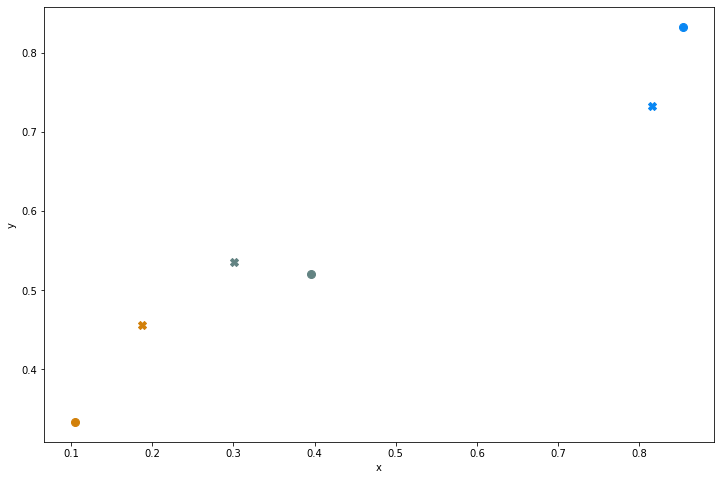

In [ ]:
data_gen.plot(conv2_model, max_plots=3, plot_ds='train')

#### Recurrent


##### LSTM1

In [ ]:
lstm1_model = tf.keras.Sequential([
    tf.keras.layers.Reshape([-1,1]),
    tfl.LSTM(64, return_sequences=True),
    tfl.LSTM(64, return_sequences=True),
    tfl.LSTM(64, return_sequences=True),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(out_cardinality)
])

lstm1_optimizer = tf.keras.optimizers.Adam()

In [ ]:
model = lstm1_model
history = compile_and_fit(model, data_train=data_gen.train, data_val=data_gen.val,
                          optimizer=lstm1_optimizer, lr=1e-3)

IPython.display.clear_output()
model.evaluate(data_gen.train)
model.evaluate(data_gen.val)
model.evaluate(data_gen.test)

In [ ]:
y_pred = lstm_model.predict(X_train_norm)

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(np.arange(len(y_pred)), y_pred[:, 0], y_pred[:, 1], label='pred')
ax.scatter(np.arange(len(Y_train_norm)), Y_train_norm[:, 0], Y_train_norm[:, 1], label='actual')

ax.set_ylim((0,1))
ax.set_zlim((0,1))
ax.legend()

## Spectrogram Models

In [ ]:
data_gen = DataGenerator(batch_size=32, period=1, map_type='spectrogram')

n_features = X_train_norm.shape[1]
out_cardinality = Y_train_norm.shape[1]
vector_shapes = data_gen.vector_shapes

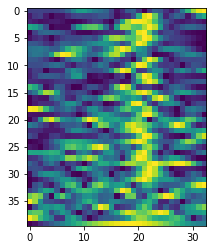

In [ ]:
x, y = next(iter(data_gen.train))
plt.imshow(x[0, ..., 0])

In [ ]:
def compile_and_fit(model, data_train, data_val, optimizer=tf.keras.optimizers.Adam(), patience=2, lr=0.001, epochs=40):
  early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience*2,
                                                    mode='min')
  reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=patience, mode='auto')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=optimizer,
                metrics=[tf.metrics.MeanAbsoluteError(), tfa.metrics.r_square.RSquare(dtype=tf.float32, y_shape=(out_cardinality,))])

  tf.keras.backend.set_value(model.optimizer.learning_rate, lr)

  history = model.fit(data_train, epochs=epochs,
                      validation_data=data_val,
                      callbacks=[reduce])
  return history

### Regression

#### Conv

##### Conv 1
Inspired by DeepSpeech2

In [ ]:
def conv1_modelf(input_shape, out_cardinality, rnn_layers=7, n_u=128, dropout_rate=0.5, kern_l2=0.0):
  X_input = tfl.Input(input_shape)
  X = X_input

  # Conv Layers
  # Stage 1
  X = tfl.Conv2D(32, [11, 41], strides=[2,2], padding='same', kernel_initializer = tf.keras.initializers.glorot_uniform(), kernel_regularizer=tf.keras.regularizers.l2(kern_l2))(X)
  X = tfl.BatchNormalization(axis=-1)(X)
  X = tfl.Activation('relu')(X)

  # Stage 2
  X = tfl.Conv2D(32, [11, 21], strides=[1,2], padding='same', kernel_initializer = tf.keras.initializers.glorot_uniform(), kernel_regularizer=tf.keras.regularizers.l2(kern_l2))(X)
  X = tfl.BatchNormalization(axis=-1)(X)
  X = tfl.Activation('relu')(X)

  # Stage 3
  X = tfl.Conv2D(64, [11, 21], strides=[1,2], padding='same', kernel_initializer = tf.keras.initializers.glorot_uniform(), kernel_regularizer=tf.keras.regularizers.l2(kern_l2))(X)
  X = tfl.BatchNormalization(axis=-1)(X)
  X = tfl.Activation('relu')(X)

  X = tfl.Conv2D(1, [1,1], kernel_initializer = tf.keras.initializers.glorot_uniform(), kernel_regularizer=tf.keras.regularizers.l2(kern_l2))(X)
  X = tfl.Lambda(lambda X: X[..., 0])(X)

  # Recurrent Layers
  for i in range(rnn_layers):
    X = tfl.Bidirectional(tfl.LSTM(n_u, return_sequences=True))(X)
    if i < rnn_layers - 1:
      X = tfl.Dropout(dropout_rate)(X)

  # Final FC‌s
  X = tfl.Flatten()(X)

  X = tfl.Dense(n_u*2, kernel_regularizer=tf.keras.regularizers.l2(kern_l2), activation='relu')(X)
  X = tfl.Dense(n_u/2, kernel_regularizer=tf.keras.regularizers.l2(kern_l2), activation='relu')(X)

  X = tfl.Dense(out_cardinality, kernel_regularizer=tf.keras.regularizers.l2(kern_l2))(X)

  return tf.keras.Model(inputs=X_input, outputs=X)

In [ ]:
conv1_model = conv1_modelf(vector_shapes[0], out_cardinality, rnn_layers=5, n_u=128, dropout_rate=0.5, kern_l2=0.0)
conv1_optimizer = tf.keras.optimizers.Adam()

conv1_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 40, 33, 1)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 17, 32)        14464     
                                                                 
 batch_normalization_41 (Bat  (None, 20, 17, 32)       128       
 chNormalization)                                                
                                                                 
 activation_41 (Activation)  (None, 20, 17, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 9, 32)         236576    
                                                                 
 batch_normalization_42 (Bat  (None, 20, 9, 32)        128       
 chNormalization)                                          

In [ ]:
model = conv1_model
optimizer=conv1_optimizer
history = compile_and_fit(model, data_train=data_gen.train, data_val=data_gen.val,
                          optimizer=optimizer, lr=1e-3, patience=4)

IPython.display.clear_output()
model.evaluate(data_gen.train)
model.evaluate(data_gen.val)
model.evaluate(data_gen.test)

Epoch 1/40
294/294 [==============================] - 67s 124ms/step - loss: 1.0121 - mean_absolute_error: 0.8696 - r_square: -0.0121 - val_loss: 0.9942 - val_mean_absolute_error: 0.8603 - val_r_square: -0.0014 - lr: 0.0010
Epoch 2/40
294/294 [==============================] - 32s 109ms/step - loss: 1.0053 - mean_absolute_error: 0.8676 - r_square: -0.0053 - val_loss: 0.9928 - val_mean_absolute_error: 0.8594 - val_r_square: 3.4064e-05 - lr: 0.0010
Epoch 3/40
294/294 [==============================] - 32s 108ms/step - loss: 1.0008 - mean_absolute_error: 0.8661 - r_square: -8.3590e-04 - val_loss: 0.9933 - val_mean_absolute_error: 0.8598 - val_r_square: -4.7660e-04 - lr: 0.0010
Epoch 4/40
294/294 [==============================] - 32s 109ms/step - loss: 1.0011 - mean_absolute_error: 0.8661 - r_square: -0.0011 - val_loss: 0.9932 - val_mean_absolute_error: 0.8600 - val_r_square: -3.7915e-04 - lr: 0.0010
Epoch 5/40
294/294 [==============================] - 32s 108ms/step - loss: 1.0011 - mea

KeyboardInterrupt: ignored

In [ ]:
data_gen.plot(conv1_model, max_plots=6, plot_ds='train')

TypeError: ignored